#   Optics Clustering

In [1]:
#IMPORTS
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from statsmodels.tsa.stattools import coint, grangercausalitytests
import warnings
import itertools
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
warnings.filterwarnings("ignore")

# Data Fetch

In [2]:
# Data
stocks = [
    # S&P for Beta
    "^GSPC",
    # Megacap Leaders & Generalists
    "NVDA", "TSM", "AVGO", "AMD", "INTC", "MU", "TXN", "QCOM", "ADI", "MCHP",
    
    # Equipment & Manufacturing
    "ASML", "AMAT", "LRCX", "KLAC", "TER", "ENTG", "NVMI", "TOELY",
    
    # Specialized
    "ON", "NXPI", "STM", "LSCC", "MPWR", "QRVO", "SWKS", "ALAB", "CRDO",
    
    # Intellectual Property & Design Software
    "ARM", "SNPS", "CDNS", "CEVA",
    
    # Memory & Storage
    "WDC", "STX", # Removed extra "MU" here
    
    # Emerging & Mid-Cap
    "GFS", "MRVL", "MTSI", "POWI", "SMTC", "VICR", "CAMT"
]

def fetch_data(stocks):
    data = yf.download(tickers=stocks, period="252d", interval="1h", group_by='ticker', auto_adjust=True, threads=True)
    
    price_series_list = []
    for s in stocks:
        try: 
            if s in data:
                series = data[s]['Close']
                series.name = s
                price_series_list.append(series)
        except Exception as e:
            pass

    if price_series_list:
        df = pd.concat(price_series_list, axis=1)
        # Market-hours-aware fill: only forward-fill within the same trading day
        # to avoid creating false correlations across overnight/weekend gaps
        df = df.groupby(df.index.date).apply(lambda g: g.ffill()).droplevel(0)
        return df
    return pd.DataFrame()

df = fetch_data(stocks)

[*********************100%***********************]  41 of 41 completed


## Factor Data Preparation

In [3]:
# ============================================================================
# FEATURE ENGINEERING FOR TRANSIENT REGIME DETECTION
# ============================================================================

# 1. Clean and Prepare Price Data
if isinstance(df.columns, pd.MultiIndex):
    if 'Close' in df.columns.get_level_values(0):
        df = df['Close']
    elif 'Close' in df.columns.get_level_values(1):
        df = df.xs('Close', axis=1, level=1)

# 2. Base Calculations
returns_df = df.pct_change().dropna()
market_returns = returns_df['^GSPC']

# ============================================================================
# CRITICAL CHANGE: Multi-Timeframe Feature Engineering
# ============================================================================

# SHORT-TERM WINDOW (Transient regime detection)
window_short = 50  # ~1 week of hourly data - ALIGNED WITH TRADE DURATION

# MEDIUM-TERM WINDOW (Context/stability check)
window_medium = 147  # ~3 weeks - your original window

print("="*80)
print("FEATURE ENGINEERING - MULTI-TIMEFRAME APPROACH")
print("="*80)
print(f"Short-term window: {window_short} hours (~1 week)")
print(f"Medium-term window: {window_medium} hours (~3 weeks)")
print(f"Optimizing for transient events: 10-50 hour duration\n")


# ============================================================================
# 3A. SHORT-TERM FEATURES (Primary clustering features)
# ============================================================================

print("Calculating SHORT-TERM features (primary regime indicators)...")

# Feature A: SHORT-TERM Volatility (Recent risk behavior)
rolling_vol_short = returns_df.rolling(window=window_short).std()

# Feature B: SHORT-TERM Beta to SPX (Recent market sensitivity)
rolling_cov_mkt_short = returns_df.rolling(window=window_short).cov(market_returns)
rolling_mkt_var_short = market_returns.rolling(window=window_short).var()
rolling_beta_spx_short = rolling_cov_mkt_short.divide(rolling_mkt_var_short, axis=0)

# Feature C: SHORT-TERM Beta to Sector (Recent sector coupling)
non_spx_returns = returns_df.drop(columns=['^GSPC'], errors='ignore').dropna(axis=1, how='all')
sector_sum = non_spx_returns.sum(axis=1)
n_stocks = non_spx_returns.count(axis=1)

# Leave-one-out sector average and rolling beta for each ticker
rolling_beta_sector_short = pd.DataFrame(index=returns_df.index, columns=non_spx_returns.columns)
for ticker in non_spx_returns.columns:
    loo_sector = (sector_sum - non_spx_returns[ticker].fillna(0)) / (n_stocks - 1).clip(lower=1)
    cov = returns_df[ticker].rolling(window=window_short).cov(loo_sector)
    var = loo_sector.rolling(window=window_short).var()
    rolling_beta_sector_short[ticker] = cov / var


# ============================================================================
# 3B. MEDIUM-TERM FEATURES (Context/stability indicators)
# ============================================================================

print("Calculating MEDIUM-TERM features (context indicators)...")

# These help identify if current behavior is unusual vs. longer-term baseline
rolling_vol_medium = returns_df.rolling(window=window_medium).std()

rolling_cov_mkt_medium = returns_df.rolling(window=window_medium).cov(market_returns)
rolling_mkt_var_medium = market_returns.rolling(window=window_medium).var()
rolling_beta_spx_medium = rolling_cov_mkt_medium.divide(rolling_mkt_var_medium, axis=0)

rolling_beta_sector_medium = pd.DataFrame(index=returns_df.index, columns=non_spx_returns.columns)
for ticker in non_spx_returns.columns:
    loo_sector = (sector_sum - non_spx_returns[ticker].fillna(0)) / (n_stocks - 1).clip(lower=1)
    cov = returns_df[ticker].rolling(window=window_medium).cov(loo_sector)
    var = loo_sector.rolling(window=window_medium).var()
    rolling_beta_sector_medium[ticker] = cov / var


# ============================================================================
# 3C. INSTANTANEOUS FEATURES (Momentum/Overbought indicators)
# ============================================================================

print("Calculating INSTANTANEOUS features (momentum indicators)...")

# Feature D: RSI (Momentum/Overextended) - 70 periods for hourly data (~2 weeks)
def calculate_rsi(data, window=70):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

rsi_df = df.apply(calculate_rsi)

# Feature E: Short Term Momentum (5-period return)
momentum_5h = df.pct_change(periods=5)

# Feature F: Momentum Acceleration (change in momentum)
momentum_10h = df.pct_change(periods=10)
momentum_acceleration = momentum_5h - momentum_5h.shift(5)


# ============================================================================
# 3D. REGIME CHANGE INDICATORS (New!)
# ============================================================================

print("Calculating REGIME CHANGE indicators...")

# Detect when short-term behavior diverges from medium-term baseline
# This helps identify when a NEW regime is forming

# Volatility Regime Shift (is vol spiking vs. baseline?)
vol_regime_shift = (rolling_vol_short - rolling_vol_medium) / rolling_vol_medium

# Beta Regime Shift (is market sensitivity changing?)
beta_spx_regime_shift = rolling_beta_spx_short - rolling_beta_spx_medium
beta_sector_regime_shift = rolling_beta_sector_short - rolling_beta_sector_medium


# ============================================================================
# 4. Assemble the Master Time-Series DataFrame (ts_df)
# ============================================================================

print("\nAssembling time-series dataframe...")

ts_data_list = []

for ticker in stocks:
    if ticker == '^GSPC' or ticker not in df.columns: 
        continue
    
    # Extract features for this specific ticker
    temp_df = pd.DataFrame({
        # Price & Returns (baseline)
        'Price': df[ticker],
        'Returns': returns_df[ticker],
        
        # SHORT-TERM FEATURES (Primary clustering features)
        'Vol_Short': rolling_vol_short[ticker],
        'Beta_SPX_Short': rolling_beta_spx_short[ticker],
        'Beta_Sector_Short': rolling_beta_sector_short[ticker],
        
        # MEDIUM-TERM FEATURES (Context)
        'Vol_Medium': rolling_vol_medium[ticker],
        'Beta_SPX_Medium': rolling_beta_spx_medium[ticker],
        'Beta_Sector_Medium': rolling_beta_sector_medium[ticker],
        
        # INSTANTANEOUS FEATURES
        'RSI': rsi_df[ticker],
        'Momentum_5H': momentum_5h[ticker],
        'Momentum_10H': momentum_10h[ticker],
        'Momentum_Accel': momentum_acceleration[ticker],
        
        # REGIME CHANGE INDICATORS (New!)
        'Vol_Regime_Shift': vol_regime_shift[ticker],
        'Beta_SPX_Regime_Shift': beta_spx_regime_shift[ticker],
        'Beta_Sector_Regime_Shift': beta_sector_regime_shift[ticker],
        
    }, index=df.index)
    
    temp_df['Ticker'] = ticker
    ts_data_list.append(temp_df)

if ts_data_list:
    ts_df = pd.concat(ts_data_list).reset_index().set_index(['Datetime', 'Ticker'])
    
    # Drop NaNs created by rolling windows
    initial_rows = len(ts_df)
    ts_df = ts_df.dropna()
    dropped_rows = initial_rows - len(ts_df)
    
    print(f"\n{'='*80}")
    print("TIME-SERIES DATAFRAME CREATED SUCCESSFULLY")
    print(f"{'='*80}")
    print(f"Total rows: {len(ts_df):,}")
    print(f"Rows dropped (NaN): {dropped_rows:,} ({dropped_rows/initial_rows:.1%})")
    print(f"Date range: {ts_df.index.get_level_values('Datetime').min()} to {ts_df.index.get_level_values('Datetime').max()}")
    print(f"Unique tickers: {ts_df.index.get_level_values('Ticker').nunique()}")
    print(f"\nFeature columns: {len([c for c in ts_df.columns if c not in ['Price', 'Returns', 'Ticker']])}")
    print("\nSample data:")
    print(ts_df.head())


# ============================================================================
# 5. OPTIONAL: Static Fundamental DataFrame (Keep or Remove?)
# ============================================================================

# NOTE: For transient regime detection, fundamentals are less relevant
# Transient coupling is driven by events/news, not fundamental similarity
# Consider REMOVING this section unless you plan to use it for filtering

print(f"\n{'='*80}")
print("SKIPPING STATIC FUNDAMENTALS (Not relevant for transient detection)")
print(f"{'='*80}")
print("Transient coupling is driven by events/market dynamics, not fundamental profiles.")
print("If you want to filter pairs by fundamentals later, re-enable this section.\n")

# Uncomment below if you want to keep fundamentals
"""
fundamental_list = []
print("Fetching Static Fundamentals...")

for ticker in stocks:
    if ticker == '^GSPC': continue
    try:
        t = yf.Ticker(ticker)
        info = t.info
        
        fundamental_list.append({
            'Ticker': ticker,
            'Sector': info.get('sector', 'Unknown'),
            'Industry': info.get('industry', 'Unknown'),
            'Market_Cap': info.get('marketCap', np.nan),
        })
    except Exception as e:
        print(f"Could not fetch data for {ticker}: {e}")
        continue

static_df = pd.DataFrame(fundamental_list).set_index('Ticker')
print("Static DataFrame (static_df) Created Successfully!")
"""

print("="*80)
print("FEATURE ENGINEERING COMPLETE - Ready for clustering")
print("="*80)

FEATURE ENGINEERING - MULTI-TIMEFRAME APPROACH
Short-term window: 50 hours (~1 week)
Medium-term window: 147 hours (~3 weeks)
Optimizing for transient events: 10-50 hour duration

Calculating SHORT-TERM features (primary regime indicators)...
Calculating MEDIUM-TERM features (context indicators)...
Calculating INSTANTANEOUS features (momentum indicators)...
Calculating REGIME CHANGE indicators...

Assembling time-series dataframe...

TIME-SERIES DATAFRAME CREATED SUCCESSFULLY
Total rows: 62,821
Rows dropped (NaN): 7,179 (10.3%)
Date range: 2025-03-11 13:30:00+00:00 to 2026-02-09 15:30:00+00:00
Unique tickers: 40

Feature columns: 13

Sample data:
                                       Price   Returns  Vol_Short  \
Datetime                  Ticker                                    
2025-03-11 13:30:00+00:00 NVDA    106.309998 -0.006634   0.015222   
2025-03-11 14:30:00+00:00 NVDA    108.894997  0.024316   0.015279   
2025-03-11 15:30:00+00:00 NVDA    108.820000 -0.000689   0.015244   


# Clustering

## Based on an Hourly Time Frame

In [4]:
# ============================================================================
# OPTICS CLUSTERING FOR TRANSIENT REGIME DETECTION
# ============================================================================

if 'ts_df' not in locals():
    raise ValueError("Please run the Feature Engineering cell to create 'ts_df' first.")

# Clean duplicates
ts_df = ts_df[~ts_df.index.duplicated(keep='first')]

# Check Density
density = ts_df.groupby(level='Datetime').size()
valid_timestamps = density[density >= 5].index

print(f"{'='*80}")
print(f"TRANSIENT REGIME DETECTION - OPTICS CLUSTERING")
print(f"{'='*80}")
print(f"Data Density: {len(valid_timestamps)} valid hourly timestamps")
print(f"Date Range: {valid_timestamps.min()} to {valid_timestamps.max()}")

# ============================================================================
# FEATURES: Short-term + regime shift indicators for transient detection
# ============================================================================
features_to_cluster = ['Returns', 'Vol_Short', 'Beta_SPX_Short', 'Beta_Sector_Short', 'RSI', 'Momentum_5H', 'Vol_Regime_Shift', 'Beta_SPX_Regime_Shift', 'Beta_Sector_Regime_Shift']
print(f"\nUsing features: {features_to_cluster}")

# ============================================================================
# CLUSTERING LOOP - Hourly Regime Detection
# ============================================================================

print(f"\n{'='*80}")
print("PHASE 1: Running OPTICS Clustering (Hourly Snapshots)")
print(f"{'='*80}")

cluster_results = []
cluster_quality_log = []

for i, ts in enumerate(valid_timestamps):
    try:
        snapshot = ts_df.xs(ts, level='Datetime')[features_to_cluster].dropna()
        if len(snapshot) < 5: 
            continue
        
        # Scale & PCA (Dimensionality Reduction)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(snapshot)
        
        pca = PCA(n_components=0.90)
        X_pca = pca.fit_transform(X_scaled)
        
        # OPTICS Clustering
        optics = OPTICS(min_samples=3, metric='euclidean', xi=0.05, min_cluster_size=3)
        optics.fit(X_pca)
        
        # ===== CLUSTER QUALITY VALIDATION (RELAXED) =====
        unique_clusters = len(set(optics.labels_)) - (1 if -1 in optics.labels_ else 0)
        noise_count = (optics.labels_ == -1).sum()
        noise_pct = noise_count / len(optics.labels_)
        total_stocks = len(optics.labels_)
        
        # Quality Metrics
        quality_metrics = {
            'Datetime': ts,
            'Total_Stocks': total_stocks,
            'Unique_Clusters': unique_clusters,
            'Noise_Count': noise_count,
            'Noise_Pct': noise_pct,
            'PCA_Components': X_pca.shape[1],
            'Variance_Explained': pca.explained_variance_ratio_.sum()
        }
        
        # RELAXED Quality Filters
        is_valid = True
        skip_reason = None
        
        if unique_clusters < 1:
            is_valid = False
            skip_reason = "No clusters found (all noise)"
        elif noise_pct > 0.75:  # Relaxed to 75%
            is_valid = False
            skip_reason = f"Too noisy ({noise_pct:.1%} noise)"
        elif unique_clusters > total_stocks * 0.75:
            is_valid = False
            skip_reason = f"Over-fragmented ({unique_clusters} clusters for {total_stocks} stocks)"
        
        quality_metrics['Is_Valid'] = is_valid
        quality_metrics['Skip_Reason'] = skip_reason
        cluster_quality_log.append(quality_metrics)
        
        # Store valid clusters
        if is_valid:
            snapshot['Cluster_ID'] = optics.labels_
            snapshot['Datetime'] = ts
            snapshot['Num_Clusters'] = unique_clusters
            snapshot['Noise_Pct'] = noise_pct
            cluster_results.append(snapshot.reset_index())
        
        # Progress indicator
        if (i + 1) % 100 == 0:
            valid_so_far = len(cluster_results)
            print(f"  Processed {i+1}/{len(valid_timestamps)} timestamps... ({valid_so_far} valid so far)")
            
    except Exception as e:
        cluster_quality_log.append({
            'Datetime': ts,
            'Total_Stocks': np.nan,
            'Unique_Clusters': np.nan,
            'Noise_Count': np.nan,
            'Noise_Pct': np.nan,
            'PCA_Components': np.nan,
            'Variance_Explained': np.nan,
            'Is_Valid': False,
            'Skip_Reason': f"Error: {str(e)[:50]}"
        })
        continue

if not cluster_results:
    raise ValueError("No valid clusters found. Check your data quality and OPTICS parameters.")

cluster_history = pd.concat(cluster_results, ignore_index=True)

print(f"\n{'='*80}")
print("PHASE 1 COMPLETE: Cluster Quality Summary")
print(f"{'='*80}")

# ============================================================================
# CLUSTER QUALITY ANALYSIS
# ============================================================================

df_quality = pd.DataFrame(cluster_quality_log)

total_timestamps = len(df_quality)
valid_timestamps_count = df_quality['Is_Valid'].sum()
invalid_timestamps_count = total_timestamps - valid_timestamps_count

print(f"\nTimestamp Analysis:")
print(f"  Total timestamps processed: {total_timestamps}")
print(f"  Valid clustering windows: {valid_timestamps_count} ({valid_timestamps_count/total_timestamps:.1%})")
print(f"  Invalid/skipped windows: {invalid_timestamps_count} ({invalid_timestamps_count/total_timestamps:.1%})")

if invalid_timestamps_count > 0:
    print(f"\nSkip Reasons:")
    skip_summary = df_quality[~df_quality['Is_Valid']]['Skip_Reason'].value_counts()
    for reason, count in skip_summary.items():
        print(f"  - {reason}: {count} ({count/invalid_timestamps_count:.1%})")

# Valid cluster statistics
valid_quality = df_quality[df_quality['Is_Valid']]
if len(valid_quality) > 0:
    print(f"\nValid Cluster Statistics:")
    print(f"  Avg clusters per timestamp: {valid_quality['Unique_Clusters'].mean():.1f}")
    print(f"  Avg noise percentage: {valid_quality['Noise_Pct'].mean():.1%}")
    print(f"  Avg PCA variance retained: {valid_quality['Variance_Explained'].mean():.1%}")

print(f"\nCluster History Generated:")
print(f"  Total rows: {len(cluster_history)}")
print(f"  Unique timestamps: {cluster_history['Datetime'].nunique()}")
print(f"  Date range: {cluster_history['Datetime'].min()} to {cluster_history['Datetime'].max()}")


# ============================================================================
# PHASE 2: Cluster Stability Analysis
# ============================================================================

print(f"\n{'='*80}")
print("PHASE 2: Analyzing Cluster Stability")
print(f"{'='*80}")

pair_co_cluster_freq = {}

for ts in cluster_history['Datetime'].unique():
    snapshot = cluster_history[cluster_history['Datetime'] == ts]
    
    for cluster_id in snapshot['Cluster_ID'].unique():
        if cluster_id == -1:
            continue
        
        members = snapshot[snapshot['Cluster_ID'] == cluster_id]['Ticker'].tolist()
        
        for s1, s2 in itertools.combinations(sorted(members), 2):
            pair_key = (s1, s2)
            
            if pair_key not in pair_co_cluster_freq:
                pair_co_cluster_freq[pair_key] = 0
            pair_co_cluster_freq[pair_key] += 1

# Calculate frequencies
total_valid_windows = cluster_history['Datetime'].nunique()

pair_stability_data = []
for pair, count in pair_co_cluster_freq.items():
    frequency = count / total_valid_windows
    pair_stability_data.append({
        'Ticker_1': pair[0],
        'Ticker_2': pair[1],
        'Pair': f"{pair[0]}-{pair[1]}",
        'Co_Cluster_Count': count,
        'Co_Cluster_Frequency': frequency,
        'Is_Stable': frequency > 0.30
    })

df_pair_stability = pd.DataFrame(pair_stability_data).sort_values('Co_Cluster_Frequency', ascending=False)

print(f"\nPair Clustering Analysis:")
print(f"  Total unique pairs observed: {len(df_pair_stability)}")
print(f"  Pairs clustered together >50% of time: {(df_pair_stability['Co_Cluster_Frequency'] > 0.50).sum()}")
print(f"  Pairs clustered together >30% of time: {(df_pair_stability['Co_Cluster_Frequency'] > 0.30).sum()}")
print(f"  Pairs clustered together <10% of time: {(df_pair_stability['Co_Cluster_Frequency'] < 0.10).sum()}")

print(f"\n{'='*80}")
print("TOP 15 MOST FREQUENTLY CO-CLUSTERED PAIRS")
print(f"{'='*80}")
print(df_pair_stability[['Pair', 'Co_Cluster_Count', 'Co_Cluster_Frequency']].head(15).to_string(index=False))

print(f"\n{'='*80}")
print("TOP 15 MOST TRANSIENT PAIRS (Rare Co-Clustering)")
print(f"{'='*80}")
transient_pairs = df_pair_stability[
    (df_pair_stability['Co_Cluster_Frequency'] > 0.05) &
    (df_pair_stability['Co_Cluster_Frequency'] < 0.20)
].sort_values('Co_Cluster_Frequency', ascending=True)
print(transient_pairs[['Pair', 'Co_Cluster_Count', 'Co_Cluster_Frequency']].head(15).to_string(index=False))


# ============================================================================
# PHASE 3: Temporal Analysis
# ============================================================================

print(f"\n{'='*80}")
print("PHASE 3: Temporal Analysis - When Do Regimes Shift?")
print(f"{'='*80}")

cluster_history['Date'] = pd.to_datetime(cluster_history['Datetime']).dt.date

daily_cluster_stats = cluster_history.groupby('Date').agg({
    'Cluster_ID': lambda x: len(set(x)) - (1 if -1 in x.values else 0),
    'Ticker': 'count'
}).rename(columns={'Cluster_ID': 'Num_Clusters', 'Ticker': 'Total_Obs'})

print(f"\nDaily Clustering Variability:")
print(f"  Days with high differentiation (>4 clusters): {(daily_cluster_stats['Num_Clusters'] > 4).sum()}")
print(f"  Days with low differentiation (≤2 clusters): {(daily_cluster_stats['Num_Clusters'] <= 2).sum()}")

mean_clusters = daily_cluster_stats['Num_Clusters'].mean()
std_clusters = daily_cluster_stats['Num_Clusters'].std()
regime_shift_days = daily_cluster_stats[
    abs(daily_cluster_stats['Num_Clusters'] - mean_clusters) > 1.5 * std_clusters
]

if len(regime_shift_days) > 0:
    print(f"\nPotential Regime Shift Days (unusual cluster patterns):")
    print(f"  {len(regime_shift_days)} days detected")
    print(f"\nTop 5 Most Unusual Days:")
    top_shifts = regime_shift_days.nlargest(5, 'Num_Clusters')
    for date, row in top_shifts.iterrows():
        print(f"  {date}: {row['Num_Clusters']:.0f} clusters (avg: {mean_clusters:.1f})")

print(f"\n{'='*80}")
print("CLUSTERING PHASE COMPLETE")
print(f"{'='*80}")
print(f"\nData structures created:")
print(f"  - cluster_history: {len(cluster_history)} rows")
print(f"  - df_quality: {len(df_quality)} rows")
print(f"  - df_pair_stability: {len(df_pair_stability)} rows")
print(f"\nReady for pair testing phase")

TRANSIENT REGIME DETECTION - OPTICS CLUSTERING
Data Density: 1578 valid hourly timestamps
Date Range: 2025-03-11 13:30:00+00:00 to 2026-02-09 15:30:00+00:00

Using features: ['Returns', 'Vol_Short', 'Beta_SPX_Short', 'Beta_Sector_Short', 'RSI', 'Momentum_5H', 'Vol_Regime_Shift', 'Beta_SPX_Regime_Shift', 'Beta_Sector_Regime_Shift']

PHASE 1: Running OPTICS Clustering (Hourly Snapshots)
  Processed 100/1578 timestamps... (77 valid so far)
  Processed 200/1578 timestamps... (171 valid so far)
  Processed 300/1578 timestamps... (262 valid so far)
  Processed 400/1578 timestamps... (336 valid so far)
  Processed 500/1578 timestamps... (424 valid so far)
  Processed 600/1578 timestamps... (518 valid so far)
  Processed 700/1578 timestamps... (599 valid so far)
  Processed 800/1578 timestamps... (689 valid so far)
  Processed 900/1578 timestamps... (777 valid so far)
  Processed 1000/1578 timestamps... (854 valid so far)
  Processed 1100/1578 timestamps... (938 valid so far)
  Processed 1200/

# Cluster Formation & Duration Analysis

In [5]:
# ============================================================================
# CLUSTER FORMATION & DISSOLUTION EVENT DETECTION
# ============================================================================
# Instead of just counting co-clustering frequency, detect the MOMENTS when
# pairs START and STOP co-clustering. These formation events are what we
# want to predict.

print(f"{'='*80}")
print("PHASE 2B: CLUSTER FORMATION & DISSOLUTION EVENTS")
print(f"{'='*80}")

# ============================================================================
# Step 1: Build a per-pair, per-timestamp co-clustering indicator
# ============================================================================

# Get all unique pairs that ever co-clustered (from Phase 2)
all_pairs = list(pair_co_cluster_freq.keys())
all_timestamps = sorted(cluster_history['Datetime'].unique())

print(f"Tracking {len(all_pairs)} pairs across {len(all_timestamps)} timestamps...")

# Build co-clustering matrix: for each pair, 1 if co-clustered at that timestamp, 0 otherwise
pair_coclustering = {}

for ts in all_timestamps:
    snapshot = cluster_history[cluster_history['Datetime'] == ts]
    coclustered_at_ts = set()
    
    for cluster_id in snapshot['Cluster_ID'].unique():
        if cluster_id == -1:
            continue
        members = sorted(snapshot[snapshot['Cluster_ID'] == cluster_id]['Ticker'].tolist())
        for s1, s2 in itertools.combinations(members, 2):
            coclustered_at_ts.add((s1, s2))
    
    for pair in all_pairs:
        if pair not in pair_coclustering:
            pair_coclustering[pair] = []
        pair_coclustering[pair].append(1 if pair in coclustered_at_ts else 0)

# ============================================================================
# Step 2: Detect Formation and Dissolution Events
# ============================================================================
# A formation event occurs when a pair transitions from NOT co-clustering
# to co-clustering (0 -> 1 transition).
# A dissolution event is the reverse (1 -> 0 transition).
# We require a minimum gap (MIN_GAP_HOURS) of non-co-clustering before a
# new formation to avoid counting brief flickers.

MIN_GAP_HOURS = 5  # Minimum hours of non-co-clustering before counting a new formation

formation_events = []
dissolution_events = []
cluster_durations = []

for pair, series in pair_coclustering.items():
    ts_series = list(zip(all_timestamps, series))
    
    in_cluster = False
    formation_ts = None
    formation_idx = None
    gap_count = MIN_GAP_HOURS  # Start with full gap so first co-clustering counts as formation
    
    for i, (ts, val) in enumerate(ts_series):
        if val == 1:
            if not in_cluster and gap_count >= MIN_GAP_HOURS:
                # Formation event: pair just started co-clustering after a sufficient gap
                in_cluster = True
                formation_ts = ts
                formation_idx = i
                formation_events.append({
                    'Ticker_1': pair[0],
                    'Ticker_2': pair[1],
                    'Pair': f"{pair[0]}-{pair[1]}",
                    'Formation_Time': ts,
                    'Timestamp_Index': i
                })
            elif not in_cluster:
                # Still in the gap period, but co-clustering again
                in_cluster = True
                formation_ts = ts
                formation_idx = i
            gap_count = 0
        else:
            if in_cluster:
                gap_count += 1
                if gap_count >= MIN_GAP_HOURS:
                    # Dissolution confirmed after sufficient gap
                    # The last co-clustering timestamp was at index (i - gap_count)
                    last_cocluster_idx = i - gap_count
                    dissolution_ts = all_timestamps[min(last_cocluster_idx + 1, len(all_timestamps) - 1)]
                    duration = max(1, last_cocluster_idx - formation_idx + 1) if formation_idx is not None else 1
                    
                    dissolution_events.append({
                        'Ticker_1': pair[0],
                        'Ticker_2': pair[1],
                        'Pair': f"{pair[0]}-{pair[1]}",
                        'Dissolution_Time': dissolution_ts,
                        'Duration_Hours': duration
                    })
                    
                    if formation_ts is not None:
                        cluster_durations.append({
                            'Ticker_1': pair[0],
                            'Ticker_2': pair[1],
                            'Pair': f"{pair[0]}-{pair[1]}",
                            'Formation_Time': formation_ts,
                            'Dissolution_Time': dissolution_ts,
                            'Duration_Hours': duration
                        })
                    
                    in_cluster = False
                    formation_ts = None
                    formation_idx = None
            else:
                gap_count += 1

    # Handle pairs still in cluster at end of series
    if in_cluster and formation_ts is not None:
        last_cocluster_idx = len(ts_series) - 1
        for j in range(len(ts_series) - 1, -1, -1):
            if ts_series[j][1] == 1:
                last_cocluster_idx = j
                break
        duration = max(1, last_cocluster_idx - formation_idx + 1) if formation_idx is not None else 1
        dissolution_ts = all_timestamps[min(last_cocluster_idx + 1, len(all_timestamps) - 1)]
        
        dissolution_events.append({
            'Ticker_1': pair[0],
            'Ticker_2': pair[1],
            'Pair': f"{pair[0]}-{pair[1]}",
            'Dissolution_Time': dissolution_ts,
            'Duration_Hours': duration
        })
        
        cluster_durations.append({
            'Ticker_1': pair[0],
            'Ticker_2': pair[1],
            'Pair': f"{pair[0]}-{pair[1]}",
            'Formation_Time': formation_ts,
            'Dissolution_Time': dissolution_ts,
            'Duration_Hours': duration
        })

df_formations = pd.DataFrame(formation_events)
df_dissolutions = pd.DataFrame(dissolution_events)
df_durations = pd.DataFrame(cluster_durations)

print(f"\nFormation events detected: {len(df_formations)}")
print(f"Dissolution events detected: {len(df_dissolutions)}")
print(f"Complete cluster episodes (formation + dissolution): {len(df_durations)}")

# ============================================================================
# Step 3: Duration Analysis
# ============================================================================

if len(df_durations) > 0:
    print(f"\n{'='*80}")
    print("CLUSTER DURATION ANALYSIS")
    print(f"{'='*80}")
    
    print(f"\nDuration Statistics (hours):")
    print(f"  Mean:   {df_durations['Duration_Hours'].mean():.1f}")
    print(f"  Median: {df_durations['Duration_Hours'].median():.1f}")
    print(f"  Min:    {df_durations['Duration_Hours'].min():.0f}")
    print(f"  Max:    {df_durations['Duration_Hours'].max():.0f}")
    print(f"  Std:    {df_durations['Duration_Hours'].std():.1f}")
    
    # Duration buckets
    short_lived = len(df_durations[df_durations['Duration_Hours'] <= 10])
    medium_lived = len(df_durations[(df_durations['Duration_Hours'] > 10) & (df_durations['Duration_Hours'] <= 50)])
    long_lived = len(df_durations[df_durations['Duration_Hours'] > 50])
    
    print(f"\nDuration Buckets:")
    print(f"  Short-lived (<=10h):  {short_lived} ({short_lived/len(df_durations):.1%})")
    print(f"  Medium (10-50h):      {medium_lived} ({medium_lived/len(df_durations):.1%})")
    print(f"  Long-lived (>50h):    {long_lived} ({long_lived/len(df_durations):.1%})")

# ============================================================================
# Step 4: Classify pairs
# ============================================================================

print(f"\n{'='*80}")
print("PAIR CLASSIFICATION")
print(f"{'='*80}")

# Transient pairs: multiple formation events with short durations
pair_formation_counts = df_formations.groupby('Pair').size().reset_index(name='Formation_Count')
pair_avg_duration = df_durations.groupby('Pair')['Duration_Hours'].mean().reset_index(name='Avg_Duration')

pair_classification = pair_formation_counts.merge(pair_avg_duration, on='Pair', how='left')
pair_classification = pair_classification.merge(
    df_pair_stability[['Pair', 'Co_Cluster_Frequency']], on='Pair', how='left'
)

# Classify
pair_classification['Category'] = 'unknown'

# Transient: multiple short-lived formations (the target use case)
transient_mask = (pair_classification['Formation_Count'] >= 3) & (pair_classification['Avg_Duration'] <= 30)
pair_classification.loc[transient_mask, 'Category'] = 'transient'

# Stable: high co-clustering frequency OR very long average duration
stable_mask = ((pair_classification['Co_Cluster_Frequency'] > 0.30) | (pair_classification['Avg_Duration'] > 100)) & (pair_classification['Category'] == 'unknown')
pair_classification.loc[stable_mask, 'Category'] = 'stable_candidate'

# Sporadic: few formation events
sporadic_mask = (pair_classification['Formation_Count'] <= 2) & (pair_classification['Category'] == 'unknown')
pair_classification.loc[sporadic_mask, 'Category'] = 'sporadic'

for cat in ['transient', 'stable_candidate', 'sporadic', 'unknown']:
    count = len(pair_classification[pair_classification['Category'] == cat])
    print(f"  {cat:20s}: {count} pairs")

# Show top transient pairs
transient_pairs_classified = pair_classification[pair_classification['Category'] == 'transient'].sort_values('Formation_Count', ascending=False)
if len(transient_pairs_classified) > 0:
    print(f"\nTop 15 Transient Pairs (target for prediction):")
    print(transient_pairs_classified[['Pair', 'Formation_Count', 'Avg_Duration', 'Co_Cluster_Frequency']].head(15).to_string(index=False))

# Show stable/cointegration candidates
stable_candidates = pair_classification[pair_classification['Category'] == 'stable_candidate'].sort_values('Co_Cluster_Frequency', ascending=False)
if len(stable_candidates) > 0:
    print(f"\nStable/Cointegration Candidates (consistently co-clustered):")
    print(stable_candidates[['Pair', 'Formation_Count', 'Avg_Duration', 'Co_Cluster_Frequency']].head(10).to_string(index=False))

print(f"\n{'='*80}")
print("FORMATION/DISSOLUTION ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"\nData structures created:")
print(f"  - df_formations: {len(df_formations)} formation events")
print(f"  - df_dissolutions: {len(df_dissolutions)} dissolution events")
print(f"  - df_durations: {len(df_durations)} complete cluster episodes")
print(f"  - pair_classification: {len(pair_classification)} pairs classified")
print(f"\nUse df_formations for validation (these are the events to test)")
print(f"Use transient pairs for prediction modeling")


PHASE 2B: CLUSTER FORMATION & DISSOLUTION EVENTS
Tracking 776 pairs across 1368 timestamps...

Formation events detected: 19883
Dissolution events detected: 19883
Complete cluster episodes (formation + dissolution): 19883

CLUSTER DURATION ANALYSIS

Duration Statistics (hours):
  Mean:   4.5
  Median: 1.0
  Min:    1
  Max:    156
  Std:    7.1

Duration Buckets:
  Short-lived (<=10h):  17693 (89.0%)
  Medium (10-50h):      2139 (10.8%)
  Long-lived (>50h):    51 (0.3%)

PAIR CLASSIFICATION
  transient           : 764 pairs
  stable_candidate    : 0 pairs
  sporadic            : 12 pairs
  unknown             : 0 pairs

Top 15 Transient Pairs (target for prediction):
     Pair  Formation_Count  Avg_Duration  Co_Cluster_Frequency
  STX-WDC               67      5.223881              0.162281
NXPI-POWI               61      6.196721              0.183480
ASML-LRCX               55      5.818182              0.144737
  NXPI-ON               54      6.611111              0.165936
QCOM-SWKS

In [6]:
# ============================================================================
# SAVE DATA FOR PREDICTION NOTEBOOK
# ============================================================================
# Persist key data structures so optics-prediction.ipynb can load them
# without requiring this notebook to be run in the same kernel session.

import os
import pickle

data_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data')
os.makedirs(data_dir, exist_ok=True)

save_items = {
    'ts_df': ts_df,
    'df_formations': df_formations,
    'pair_classification': pair_classification,
    'cluster_history': cluster_history,
}

for name, obj in save_items.items():
    path = os.path.join(data_dir, f'{name}.pkl')
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
    print(f'Saved {name} -> {path} ({len(obj)} rows)')

print(f'\nAll data saved to {data_dir}/')
print('optics-prediction.ipynb can now load these files independently.')

Saved ts_df -> /Users/jack/Documents/code/pairs-test/research/data/ts_df.pkl (62821 rows)
Saved df_formations -> /Users/jack/Documents/code/pairs-test/research/data/df_formations.pkl (19883 rows)
Saved pair_classification -> /Users/jack/Documents/code/pairs-test/research/data/pair_classification.pkl (776 rows)
Saved cluster_history -> /Users/jack/Documents/code/pairs-test/research/data/cluster_history.pkl (54426 rows)

All data saved to /Users/jack/Documents/code/pairs-test/research/data/
optics-prediction.ipynb can now load these files independently.


# Correctness Checks: Random Baseline, Out-of-Sample, Sensitivity

In [7]:
# ============================================================================
# CORRECTNESS CHECKS: Random Baseline, Out-of-Sample Split, OPTICS Sensitivity
# ============================================================================

import itertools

# ============================================================================
# 1. RANDOM BASELINE (Permutation Test)
# ============================================================================
# Shuffle cluster labels across stocks at each timestamp to establish
# a null distribution. If observed co-clustering exceeds this, results
# are meaningful.

print(f"{'='*80}")
print("CORRECTNESS CHECK 1: Random Baseline (Permutation Test)")
print(f"{'='*80}")

N_PERMUTATIONS = 100
observed_mean_freq = df_pair_stability['Co_Cluster_Frequency'].mean()

null_mean_freqs = []

for perm in range(N_PERMUTATIONS):
    perm_pair_counts = {}
    
    for ts in cluster_history['Datetime'].unique():
        snapshot = cluster_history[cluster_history['Datetime'] == ts].copy()
        
        # Shuffle cluster labels across stocks at this timestamp
        shuffled_labels = snapshot['Cluster_ID'].values.copy()
        np.random.shuffle(shuffled_labels)
        snapshot = snapshot.copy()
        snapshot['Cluster_ID'] = shuffled_labels
        
        for cluster_id in snapshot['Cluster_ID'].unique():
            if cluster_id == -1:
                continue
            members = sorted(snapshot[snapshot['Cluster_ID'] == cluster_id]['Ticker'].tolist())
            for s1, s2 in itertools.combinations(members, 2):
                pair_key = (s1, s2)
                perm_pair_counts[pair_key] = perm_pair_counts.get(pair_key, 0) + 1
    
    total_windows = cluster_history['Datetime'].nunique()
    if perm_pair_counts:
        mean_freq = np.mean([c / total_windows for c in perm_pair_counts.values()])
    else:
        mean_freq = 0
    null_mean_freqs.append(mean_freq)

null_mean = np.mean(null_mean_freqs)
null_std = np.std(null_mean_freqs)
z_vs_null = (observed_mean_freq - null_mean) / null_std if null_std > 0 else 0
p_value = np.mean([n >= observed_mean_freq for n in null_mean_freqs])

print(f"\nObserved mean co-clustering frequency: {observed_mean_freq:.4f}")
print(f"Null distribution mean: {null_mean:.4f} (+/- {null_std:.4f})")
print(f"Z-score vs null: {z_vs_null:.2f}")
print(f"Empirical p-value: {p_value:.4f}")

if p_value < 0.05:
    print("RESULT: Co-clustering significantly exceeds random chance (p < 0.05)")
else:
    print("WARNING: Co-clustering does NOT significantly exceed random chance")

# ============================================================================
# 2. OUT-OF-SAMPLE SPLIT
# ============================================================================

print(f"\n{'='*80}")
print("CORRECTNESS CHECK 2: Out-of-Sample Split")
print(f"{'='*80}")

all_dates = sorted(cluster_history['Datetime'].unique())
split_point = int(len(all_dates) * 0.67)  # First 67% for training, last 33% for test
split_timestamp = all_dates[split_point]

train_history = cluster_history[cluster_history['Datetime'] <= split_timestamp]
test_history = cluster_history[cluster_history['Datetime'] > split_timestamp]

print(f"\nSplit point: {split_timestamp}")
print(f"Training period: {all_dates[0]} to {split_timestamp} ({len(train_history)} rows)")
print(f"Test period: {split_timestamp} to {all_dates[-1]} ({len(test_history)} rows)")

# Calculate co-clustering frequency in both periods
def calc_pair_freq(history_df):
    freq = {}
    total = history_df['Datetime'].nunique()
    for ts in history_df['Datetime'].unique():
        snap = history_df[history_df['Datetime'] == ts]
        for cid in snap['Cluster_ID'].unique():
            if cid == -1:
                continue
            members = sorted(snap[snap['Cluster_ID'] == cid]['Ticker'].tolist())
            for s1, s2 in itertools.combinations(members, 2):
                freq[(s1, s2)] = freq.get((s1, s2), 0) + 1
    return {k: v / total for k, v in freq.items()}

train_freq = calc_pair_freq(train_history)
test_freq = calc_pair_freq(test_history)

# Compare: do pairs that co-cluster frequently in training also do so in test?
common_pairs = set(train_freq.keys()) & set(test_freq.keys())
if len(common_pairs) > 0:
    train_vals = [train_freq[p] for p in common_pairs]
    test_vals = [test_freq[p] for p in common_pairs]
    from scipy.stats import pearsonr
    oos_corr, oos_pval = pearsonr(train_vals, test_vals)
    
    print(f"\nPairs observed in both periods: {len(common_pairs)}")
    print(f"Correlation of co-clustering frequency (train vs test): {oos_corr:.3f} (p={oos_pval:.4f})")
    
    if oos_corr > 0.5:
        print("RESULT: Good out-of-sample stability - co-clustering patterns persist")
    elif oos_corr > 0.2:
        print("RESULT: Moderate out-of-sample stability")
    else:
        print("WARNING: Poor out-of-sample stability - patterns may not generalize")
else:
    print("WARNING: No common pairs between train and test periods")

# Store split info for use in validation
oos_split_timestamp = split_timestamp
print(f"\nStoredoos_split_timestamp = {oos_split_timestamp} for validation phase")

# ============================================================================
# 3. OPTICS PARAMETER SENSITIVITY CHECK
# ============================================================================

print(f"\n{'='*80}")
print("CORRECTNESS CHECK 3: OPTICS Parameter Sensitivity")
print(f"{'='*80}")

# Test different parameter combinations on a sample of timestamps
param_configs = [
    {'min_samples': 2, 'xi': 0.05, 'min_cluster_size': 2},
    {'min_samples': 3, 'xi': 0.05, 'min_cluster_size': 3},  # Current default
    {'min_samples': 3, 'xi': 0.03, 'min_cluster_size': 3},
    {'min_samples': 5, 'xi': 0.05, 'min_cluster_size': 5},
    {'min_samples': 3, 'xi': 0.10, 'min_cluster_size': 3},
]

features_to_cluster = ['Returns', 'Vol_Short', 'Beta_SPX_Short', 'Beta_Sector_Short', 'RSI', 'Momentum_5H', 'Vol_Regime_Shift', 'Beta_SPX_Regime_Shift', 'Beta_Sector_Regime_Shift']

# Sample timestamps for speed
sample_timestamps = valid_timestamps[::max(1, len(valid_timestamps) // 50)][:50]

print(f"Testing {len(param_configs)} parameter configs on {len(sample_timestamps)} timestamps...\n")

sensitivity_results = []
for config in param_configs:
    config_clusters = []
    config_noise = []
    
    for ts in sample_timestamps:
        try:
            snapshot = ts_df.xs(ts, level='Datetime')[features_to_cluster].dropna()
            if len(snapshot) < 5:
                continue
            
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(snapshot)
            pca = PCA(n_components=0.90)
            X_pca = pca.fit_transform(X_scaled)
            
            optics = OPTICS(
                min_samples=config['min_samples'],
                metric='euclidean',
                xi=config['xi'],
                min_cluster_size=config['min_cluster_size']
            )
            optics.fit(X_pca)
            
            n_clusters = len(set(optics.labels_)) - (1 if -1 in optics.labels_ else 0)
            noise_pct = (optics.labels_ == -1).sum() / len(optics.labels_)
            config_clusters.append(n_clusters)
            config_noise.append(noise_pct)
        except Exception:
            continue
    
    if config_clusters:
        sensitivity_results.append({
            'min_samples': config['min_samples'],
            'xi': config['xi'],
            'min_cluster_size': config['min_cluster_size'],
            'avg_clusters': np.mean(config_clusters),
            'avg_noise_pct': np.mean(config_noise),
            'std_clusters': np.std(config_clusters)
        })

df_sensitivity = pd.DataFrame(sensitivity_results)
print("Parameter Sensitivity Results:")
print(df_sensitivity.to_string(index=False))

# Flag the current config
print(f"\nCurrent config: min_samples=3, xi=0.05, min_cluster_size=3")
if len(df_sensitivity) > 1:
    cv = df_sensitivity['std_clusters'] / df_sensitivity['avg_clusters'].replace(0, np.nan)
    if cv.max() > 1.0:
        print("WARNING: Results are highly sensitive to parameters. Consider testing more configs.")
    else:
        print("Results are reasonably stable across parameter choices.")

print(f"\n{'='*80}")
print("ALL CORRECTNESS CHECKS COMPLETE")
print(f"{'='*80}")


CORRECTNESS CHECK 1: Random Baseline (Permutation Test)

Observed mean co-clustering frequency: 0.0531
Null distribution mean: 0.0528 (+/- 0.0000)
Z-score vs null: 30997736176930.34
Empirical p-value: 0.0000
RESULT: Co-clustering significantly exceeds random chance (p < 0.05)

CORRECTNESS CHECK 2: Out-of-Sample Split

Split point: 2025-10-21 17:30:00+00:00
Training period: 2025-03-11 13:30:00+00:00 to 2025-10-21 17:30:00+00:00 (36670 rows)
Test period: 2025-10-21 17:30:00+00:00 to 2026-02-09 15:30:00+00:00 (17756 rows)

Pairs observed in both periods: 750
Correlation of co-clustering frequency (train vs test): 0.658 (p=0.0000)
RESULT: Good out-of-sample stability - co-clustering patterns persist

Storedoos_split_timestamp = 2025-10-21 17:30:00+00:00 for validation phase

CORRECTNESS CHECK 3: OPTICS Parameter Sensitivity
Testing 5 parameter configs on 50 timestamps...

Parameter Sensitivity Results:
 min_samples   xi  min_cluster_size  avg_clusters  avg_noise_pct  std_clusters
         

# Validation

In [8]:
# ============================================================================
# CELL 1: HELPER FUNCTIONS FOR PAIR VALIDATION
# ============================================================================

print("Setting up validation functions...")

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd

def get_price_window(ticker, timestamp, window_obs, ts_df, direction='forward'):
    """
    Extract price data for a ticker over a window of N observations.
    Handles the MultiIndex (Datetime, Ticker) structure of ts_df.
    
    window_obs: number of trading-hour observations (not calendar hours)
    direction='forward': window starts at timestamp, extends into future (post-T persistence test)
    direction='backward': window ends at timestamp, extends into past (legacy behavior)
    """
    try:
        # Extract all data for this ticker, sorted by time
        ticker_data = ts_df.xs(ticker, level='Ticker').sort_index()
        
        if timestamp not in ticker_data.index:
            # Find nearest timestamp
            idx_pos = ticker_data.index.searchsorted(timestamp)
            if idx_pos >= len(ticker_data.index):
                return pd.Series(dtype=float)
            timestamp = ticker_data.index[idx_pos]
        
        loc = ticker_data.index.get_loc(timestamp)
        
        if direction == 'forward':
            end_loc = min(loc + window_obs, len(ticker_data))
            window_data = ticker_data.iloc[loc:end_loc]['Price']
        else:
            start_loc = max(0, loc - window_obs + 1)
            window_data = ticker_data.iloc[start_loc:loc + 1]['Price']
        
        return window_data
    except Exception as e:
        return pd.Series(dtype=float)

def calculate_hedge_ratio_and_spread(prices_a, prices_b):
    """
    Calculate optimal hedge ratio and spread using linear regression.
    Returns hedge_ratio, spread, and R-squared.
    """
    if len(prices_a) < 2 or len(prices_b) < 2:
        return None, None, None
    
    # Align indices
    common_idx = prices_a.index.intersection(prices_b.index)
    if len(common_idx) < 2:
        return None, None, None
    
    prices_a_aligned = prices_a.loc[common_idx]
    prices_b_aligned = prices_b.loc[common_idx]
    
    # Linear regression: prices_a = hedge_ratio * prices_b + intercept
    X = prices_b_aligned.values.reshape(-1, 1)
    y = prices_a_aligned.values
    
    model = LinearRegression()
    model.fit(X, y)
    
    hedge_ratio = model.coef_[0]
    intercept = model.intercept_
    
    # Calculate spread
    spread = prices_a_aligned - hedge_ratio * prices_b_aligned
    
    # Calculate R-squared
    y_pred = hedge_ratio * prices_b_aligned + intercept
    ss_res = np.sum((prices_a_aligned - y_pred) ** 2)
    ss_tot = np.sum((prices_a_aligned - prices_a_aligned.mean()) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    return hedge_ratio, spread, r_squared

def test_correlation(prices_a, prices_b, threshold=0.50):
    """
    Test correlation on RETURNS (pct_change), not raw price levels.
    Raw price correlation is spurious for trending series — two independent
    stocks both going up will show r > 0.90 on levels alone.
    Returns-based correlation > 0.4-0.5 on hourly data is genuinely significant.
    """
    if len(prices_a) < 5 or len(prices_b) < 5:
        return None
    
    # Convert to returns to remove shared trend
    ret_a = prices_a.pct_change().dropna()
    ret_b = prices_b.pct_change().dropna()
    
    # Align indices
    common_idx = ret_a.index.intersection(ret_b.index)
    if len(common_idx) < 20:
        return None
    
    ret_a_aligned = ret_a.loc[common_idx]
    ret_b_aligned = ret_b.loc[common_idx]
    
    try:
        corr, pvalue = pearsonr(ret_a_aligned, ret_b_aligned)
        return {
            'correlation': corr,
            'pvalue': pvalue,
            'passed': corr > threshold and pvalue < 0.05
        }
    except Exception:
        return None

def test_spread_stability(prices_a, prices_b, cv_threshold=0.10):
    """
    Test spread stability normalized by PRICE LEVEL, not spread mean.
    
    Old bug: CV = spread_std / spread_mean. A perfect mean-reverting pair
    with spread_mean near 0 gets CV → infinity, falsely rejecting it.
    
    Fix: spread_cv = spread_std / avg_price_level. This measures
    "spread volatility as a % of the asset price" — stable and interpretable.
    e.g., 0.02 = spread fluctuates by 2% of the stock price.
    """
    if len(prices_a) < 3 or len(prices_b) < 3:
        return None
    
    hedge_ratio, spread, r_squared = calculate_hedge_ratio_and_spread(prices_a, prices_b)
    
    if spread is None or len(spread) < 3:
        return None
    
    spread_mean = spread.mean()
    spread_std = spread.std()
    
    # Normalize by average price level (not spread mean)
    avg_price = (prices_a.mean() + prices_b.mean()) / 2
    if avg_price == 0:
        spread_cv = float('inf')
    else:
        spread_cv = spread_std / avg_price
    
    return {
        'hedge_ratio': hedge_ratio,
        'spread_cv': spread_cv,
        'spread_mean': spread_mean,
        'spread_std': spread_std,
        'r_squared': r_squared,
        'passed': spread_cv < cv_threshold and r_squared > 0.50
    }

def test_cointegration(prices_a, prices_b, pvalue_threshold=0.05):
    """Test for cointegration using Engle-Granger.
    Requires 100+ observations for statistical reliability."""
    if len(prices_a) < 100 or len(prices_b) < 100:
        return None
    
    # Align indices
    common_idx = prices_a.index.intersection(prices_b.index)
    if len(common_idx) < 100:
        return None
    
    prices_a_aligned = prices_a.loc[common_idx]
    prices_b_aligned = prices_b.loc[common_idx]
    
    try:
        score, pvalue, _ = coint(prices_a_aligned, prices_b_aligned)
        return {
            'test_statistic': score,
            'pvalue': pvalue,
            'passed': pvalue < pvalue_threshold
        }
    except Exception:
        return None

def test_mean_reversion_speed(prices_a, prices_b):
    """Calculate half-life of mean reversion for the spread."""
    if len(prices_a) < 10 or len(prices_b) < 10:
        return None
    
    hedge_ratio, spread, _ = calculate_hedge_ratio_and_spread(prices_a, prices_b)
    
    if spread is None or len(spread) < 10:
        return None
    
    # Calculate lagged spread for AR(1) model
    spread_lag = spread.shift(1).dropna()
    spread_diff = spread.diff().dropna()
    
    if len(spread_lag) < 5:
        return None
    
    # Align
    common_idx = spread_lag.index.intersection(spread_diff.index)
    if len(common_idx) < 5:
        return None
    
    spread_lag = spread_lag.loc[common_idx]
    spread_diff = spread_diff.loc[common_idx]
    
    try:
        X_ar = spread_lag.values.reshape(-1, 1)
        y_ar = spread_diff.values
        model_ar = LinearRegression()
        model_ar.fit(X_ar, y_ar)
        beta = model_ar.coef_[0]
        
        # Calculate half-life
        if beta < 0:
            half_life = -np.log(2) / beta
        else:
            half_life = float('inf')
        
        is_mean_reverting = beta < 0 and half_life < 50
        
        return {
            'ar1_coefficient': beta,
            'half_life_hours': half_life if half_life != float('inf') else None,
            'is_mean_reverting': is_mean_reverting,
            'passed': is_mean_reverting
        }
    except Exception:
        return None

print("✓ Helper functions loaded successfully")

Setting up validation functions...
✓ Helper functions loaded successfully


In [9]:
# ============================================================================
# CELL 2: RUN PAIR VALIDATION
# ============================================================================

print(f"\n{'='*80}")
print("PHASE 4: VALIDATING TRADEABLE RELATIONSHIPS FROM CLUSTERS")
print(f"{'='*80}")

# ============================================================================
# CONFIGURATION
# ============================================================================

SHORT_WINDOW = 50   # Primary test window (hours) - aligned with feature engineering window_short
MEDIUM_WINDOW = 147 # Validation window (hours) - aligned with feature engineering window_medium

CORRELATION_THRESHOLD = 0.50   # Returns-based correlation (not price levels); > 0.5 is significant on hourly data
SPREAD_CV_THRESHOLD = 0.05   # Spread vol as % of price; 0.05 = spread fluctuates by 5% of asset price
MIN_OBSERVATIONS = 30

# Limit for testing
MAX_PAIRS_TO_TEST = 50
MAX_EVENTS_PER_PAIR = 20

print(f"\nConfiguration:")
print(f"  Test windows: {SHORT_WINDOW}h (primary), {MEDIUM_WINDOW}h (validation)")
print(f"  Correlation threshold: {CORRELATION_THRESHOLD}")
print(f"  Spread CV threshold: {SPREAD_CV_THRESHOLD}")
print(f"  Testing up to {MAX_PAIRS_TO_TEST} pairs with {MAX_EVENTS_PER_PAIR} events each")

# ============================================================================
# SELECT PAIRS TO TEST — Use formation events from Phase 2B
# ============================================================================
# Instead of filtering by co-clustering frequency bands, use the classified
# transient pairs (pairs with multiple short-lived formation events).

if 'pair_classification' in dir() and len(pair_classification) > 0:
    classified_transient = pair_classification[pair_classification['Category'] == 'transient']
    transient_pair_names = set(classified_transient['Pair'].values)
    transient_pairs = df_pair_stability[df_pair_stability['Pair'].isin(transient_pair_names)].head(MAX_PAIRS_TO_TEST)
    print(f"\n✓ Selected {len(transient_pairs)} transient pairs (from formation event classification)")
else:
    # Fallback: use frequency bands if formation analysis hasn't run
    MIN_COCLUB_FREQ = 0.05
    MAX_COCLUB_FREQ = 0.30
    transient_pairs = df_pair_stability[
        (df_pair_stability['Co_Cluster_Frequency'] >= MIN_COCLUB_FREQ) &
        (df_pair_stability['Co_Cluster_Frequency'] <= MAX_COCLUB_FREQ)
    ].head(MAX_PAIRS_TO_TEST)
    print(f"\n✓ Selected {len(transient_pairs)} pairs by frequency (fallback)")

if len(transient_pairs) == 0:
    print("\nERROR: No pairs found. Check clustering results.")
else:
    print(f"  Frequency range: {transient_pairs['Co_Cluster_Frequency'].min():.2%} - {transient_pairs['Co_Cluster_Frequency'].max():.2%}")

# ============================================================================
# VALIDATION LOOP
# ============================================================================

print(f"\nStarting validation (this may take 2-5 minutes)...")

validation_results = []
pairs_tested = 0
events_tested = 0
successful_tests = 0

for idx, pair_row in transient_pairs.iterrows():
    ticker_a = pair_row['Ticker_1']
    ticker_b = pair_row['Ticker_2']
    pairs_tested += 1
    
    # Use formation events (moments when pair STARTS co-clustering)
    pair_name = f"{ticker_a}-{ticker_b}"
    if 'df_formations' in dir() and len(df_formations) > 0:
        pair_formations = df_formations[df_formations['Pair'] == pair_name]
        if len(pair_formations) > 0:
            co_cluster_events = pair_formations.rename(columns={'Formation_Time': 'Datetime'}).head(MAX_EVENTS_PER_PAIR)
        else:
            # Fallback to all co-clustering timestamps
            timestamps_a = cluster_history[cluster_history['Ticker'] == ticker_a][['Datetime', 'Cluster_ID']]
            timestamps_b = cluster_history[cluster_history['Ticker'] == ticker_b][['Datetime', 'Cluster_ID']]
            co_cluster_events = pd.merge(timestamps_a, timestamps_b, on=['Datetime', 'Cluster_ID'], suffixes=('_a', '_b'))
            co_cluster_events = co_cluster_events[co_cluster_events['Cluster_ID'] != -1].head(MAX_EVENTS_PER_PAIR)
    else:
        timestamps_a = cluster_history[cluster_history['Ticker'] == ticker_a][['Datetime', 'Cluster_ID']]
        timestamps_b = cluster_history[cluster_history['Ticker'] == ticker_b][['Datetime', 'Cluster_ID']]
        co_cluster_events = pd.merge(timestamps_a, timestamps_b, on=['Datetime', 'Cluster_ID'], suffixes=('_a', '_b'))
        co_cluster_events = co_cluster_events[co_cluster_events['Cluster_ID'] != -1].head(MAX_EVENTS_PER_PAIR)
    
    # Test each event
    for _, event in co_cluster_events.iterrows():
        timestamp = event['Datetime']
        events_tested += 1
        
        # Test with SHORT window (FORWARD-looking: does relationship persist after detection?)
        prices_a = get_price_window(ticker_a, timestamp, SHORT_WINDOW, ts_df, direction='forward')
        prices_b = get_price_window(ticker_b, timestamp, SHORT_WINDOW, ts_df, direction='forward')
        
        if len(prices_a) >= MIN_OBSERVATIONS and len(prices_b) >= MIN_OBSERVATIONS:
            # Align prices
            common_idx = prices_a.index.intersection(prices_b.index)
            pa_aligned = prices_a.loc[common_idx]
            pb_aligned = prices_b.loc[common_idx]

            if len(pa_aligned) >= MIN_OBSERVATIONS:
                split = len(pa_aligned) // 2
                # Calibration half: estimate hedge ratio
                pa_cal, pb_cal = pa_aligned.iloc[:split], pb_aligned.iloc[:split]
                # Holdout half: test persistence
                pa_test, pb_test = pa_aligned.iloc[split:], pb_aligned.iloc[split:]

                result = {
                    'ticker_a': ticker_a,
                    'ticker_b': ticker_b,
                    'timestamp': timestamp,
                    'window_hours': SHORT_WINDOW,
                    'n_observations': len(pa_test),
                    'test_window': 'short'
                }

                # Compute hedge ratio on calibration half
                cal_hedge = calculate_hedge_ratio_and_spread(pa_cal, pb_cal)
                if cal_hedge[0] is not None:
                    hedge_ratio_cal = cal_hedge[0]
                    # Test correlation on holdout using returns
                    corr_result = test_correlation(pa_test, pb_test, CORRELATION_THRESHOLD)
                    # Test spread stability on holdout using calibration hedge ratio
                    spread_test = pa_test - hedge_ratio_cal * pb_test
                    avg_price_test = (pa_test.mean() + pb_test.mean()) / 2
                    spread_cv_test = spread_test.std() / avg_price_test if avg_price_test != 0 else float('inf')
                    r_sq_cal = cal_hedge[2]

                    spread_passed = spread_cv_test < SPREAD_CV_THRESHOLD and r_sq_cal > 0.50

                    result['hedge_ratio'] = hedge_ratio_cal
                    result['spread_cv'] = spread_cv_test
                    result['spread_mean'] = spread_test.mean()
                    result['spread_std'] = spread_test.std()
                    result['r_squared'] = r_sq_cal

                    result['spread_passed'] = spread_passed

                    if corr_result:
                        result['correlation'] = corr_result['correlation']
                        result['corr_pvalue'] = corr_result['pvalue']
                        result['corr_passed'] = corr_result['passed']

                    coint_result = test_cointegration(pa_test, pb_test)
                    if coint_result:
                        result['coint_pvalue'] = coint_result['pvalue']
                        result['coint_passed'] = coint_result['passed']

                    mr_result = test_mean_reversion_speed(pa_test, pb_test)
                    if mr_result:
                        result['half_life_hours'] = mr_result['half_life_hours']
                        result['mr_passed'] = mr_result['passed']

                    result['overall_passed'] = (
                        result.get('corr_passed', False) and
                        result.get('spread_passed', False)
                    )

                    methods_passed = sum([
                        result.get('corr_passed', False),
                        result.get('spread_passed', False),
                        result.get('coint_passed', False),
                        result.get('mr_passed', False)
                    ])
                    result['methods_passed'] = methods_passed

                    validation_results.append(result)
                    successful_tests += 1
        
        # Also test MEDIUM window (FORWARD-looking) with calibration/holdout split
        prices_a_med = get_price_window(ticker_a, timestamp, MEDIUM_WINDOW, ts_df, direction='forward')
        prices_b_med = get_price_window(ticker_b, timestamp, MEDIUM_WINDOW, ts_df, direction='forward')
        
        if len(prices_a_med) >= MIN_OBSERVATIONS and len(prices_b_med) >= MIN_OBSERVATIONS:
            # Align prices
            common_idx = prices_a_med.index.intersection(prices_b_med.index)
            pa_aligned = prices_a_med.loc[common_idx]
            pb_aligned = prices_b_med.loc[common_idx]

            if len(pa_aligned) >= MIN_OBSERVATIONS:
                split = len(pa_aligned) // 2
                # Calibration half: estimate hedge ratio
                pa_cal, pb_cal = pa_aligned.iloc[:split], pb_aligned.iloc[:split]
                # Holdout half: test persistence
                pa_test, pb_test = pa_aligned.iloc[split:], pb_aligned.iloc[split:]

                result_med = {
                    'ticker_a': ticker_a,
                    'ticker_b': ticker_b,
                    'timestamp': timestamp,
                    'window_hours': MEDIUM_WINDOW,
                    'n_observations': len(pa_test),
                    'test_window': 'medium'
                }

                # Compute hedge ratio on calibration half
                cal_hedge = calculate_hedge_ratio_and_spread(pa_cal, pb_cal)
                if cal_hedge[0] is not None:
                    hedge_ratio_cal = cal_hedge[0]
                    # Test correlation on holdout using returns
                    corr_result = test_correlation(pa_test, pb_test, CORRELATION_THRESHOLD)
                    # Test spread stability on holdout using calibration hedge ratio
                    spread_test = pa_test - hedge_ratio_cal * pb_test
                    avg_price_test = (pa_test.mean() + pb_test.mean()) / 2
                    spread_cv_test = spread_test.std() / avg_price_test if avg_price_test != 0 else float('inf')
                    r_sq_cal = cal_hedge[2]

                    spread_passed = spread_cv_test < SPREAD_CV_THRESHOLD and r_sq_cal > 0.50

                    result_med['hedge_ratio'] = hedge_ratio_cal
                    result_med['spread_cv'] = spread_cv_test
                    result_med['spread_mean'] = spread_test.mean()
                    result_med['spread_std'] = spread_test.std()
                    result_med['r_squared'] = r_sq_cal

                    result_med['spread_passed'] = spread_passed

                    if corr_result:
                        result_med['correlation'] = corr_result['correlation']
                        result_med['corr_pvalue'] = corr_result['pvalue']
                        result_med['corr_passed'] = corr_result['passed']

                    coint_result = test_cointegration(pa_test, pb_test)
                    if coint_result:
                        result_med['coint_pvalue'] = coint_result['pvalue']
                        result_med['coint_passed'] = coint_result['passed']

                    mr_result = test_mean_reversion_speed(pa_test, pb_test)
                    if mr_result:
                        result_med['half_life_hours'] = mr_result['half_life_hours']
                        result_med['mr_passed'] = mr_result['passed']

                    result_med['overall_passed'] = (
                        result_med.get('corr_passed', False) and
                        result_med.get('spread_passed', False)
                    )

                    methods_passed = sum([
                        result_med.get('corr_passed', False),
                        result_med.get('spread_passed', False),
                        result_med.get('coint_passed', False),
                        result_med.get('mr_passed', False)
                    ])
                    result_med['methods_passed'] = methods_passed

                    validation_results.append(result_med)
                    successful_tests += 1
    
    # Progress update
    if pairs_tested % 10 == 0:
        print(f"  Progress: {pairs_tested}/{len(transient_pairs)} pairs ({successful_tests} valid tests)")

print(f"\n✓ Validation complete!")
print(f"  Pairs tested: {pairs_tested}")
print(f"  Clustering events: {events_tested}")
print(f"  Valid tests: {successful_tests}")

# ============================================================================
# CREATE RESULTS DATAFRAME
# ============================================================================

df_validation = pd.DataFrame(validation_results)

print(f"\n{'='*80}")
print(f"VALIDATION RESULTS: {len(df_validation)} test results")
print(f"{'='*80}")

if len(df_validation) == 0:
    print("\n⚠ WARNING: No valid test results!")
    print("Possible issues:")
    print("  1. ts_df doesn't have enough data in test windows")
    print("  2. Timestamps in cluster_history don't match ts_df index")
    print("  3. Need to adjust MIN_OBSERVATIONS or window sizes")
else:
    print(f"\n✓ Successfully generated {len(df_validation)} test results")
    print(f"  Date range: {df_validation['timestamp'].min()} to {df_validation['timestamp'].max()}")
    print(f"  Avg observations per test: {df_validation['n_observations'].mean():.1f} hours")


PHASE 4: VALIDATING TRADEABLE RELATIONSHIPS FROM CLUSTERS

Configuration:
  Test windows: 50h (primary), 147h (validation)
  Correlation threshold: 0.5
  Spread CV threshold: 0.05
  Testing up to 50 pairs with 20 events each

✓ Selected 50 transient pairs (from formation event classification)
  Frequency range: 12.43% - 37.28%

Starting validation (this may take 2-5 minutes)...
  Progress: 10/50 pairs (400 valid tests)
  Progress: 20/50 pairs (800 valid tests)
  Progress: 30/50 pairs (1200 valid tests)
  Progress: 40/50 pairs (1600 valid tests)
  Progress: 50/50 pairs (2000 valid tests)

✓ Validation complete!
  Pairs tested: 50
  Clustering events: 1000
  Valid tests: 2000

VALIDATION RESULTS: 2000 test results

✓ Successfully generated 2000 test results
  Date range: 2025-03-11 13:30:00+00:00 to 2025-10-20 13:30:00+00:00
  Avg observations per test: 49.5 hours


In [10]:
# ============================================================================
# CELL 3: ANALYZE VALIDATION RESULTS
# ============================================================================

print(f"\n{'='*80}")
print("DETAILED RESULTS ANALYSIS")
print(f"{'='*80}")

if len(df_validation) == 0:
    print("\nNo results to analyze. Run Cell 2 first.")
else:
    # ========================================================================
    # METHOD PASS RATES
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("METHOD PERFORMANCE")
    print(f"{'='*80}")
    
    methods = [
        ('Correlation (>0.50)', 'corr_passed'),
        ('Spread Stability (CV<0.05)', 'spread_passed'),
        ('Cointegration (p<0.05)', 'coint_passed'),
        ('Mean Reversion', 'mr_passed'),
        ('OVERALL (Corr + Spread)', 'overall_passed')
    ]
    
    for method_name, col in methods:
        if col in df_validation.columns:
            pass_count = df_validation[col].sum()
            total = df_validation[col].notna().sum()
            if total > 0:
                pass_rate = pass_count / total
                print(f"{method_name:35s}: {pass_count:4d} / {total:4d} ({pass_rate:6.1%})")
    
    # ========================================================================
    # TRADEABLE OPPORTUNITIES
    # ========================================================================
    
    tradeable = df_validation[df_validation['overall_passed'] == True]
    
    print(f"\n{'='*80}")
    print(f"TRADEABLE OPPORTUNITIES FOUND: {len(tradeable)}")
    print(f"{'='*80}")
    
    if len(tradeable) > 0:
        print(f"\nSuccess rate: {len(tradeable) / len(df_validation):.1%} of tested events")
        
        # By window
        print(f"\nBy test window:")
        for window in tradeable['test_window'].unique():
            count = len(tradeable[tradeable['test_window'] == window])
            print(f"  {window.capitalize()}: {count} opportunities")
        
        # Top pairs
        print(f"\n{'='*80}")
        print("TOP 10 PAIRS WITH MOST OPPORTUNITIES")
        print(f"{'='*80}")
        
        pair_counts = tradeable.groupby(['ticker_a', 'ticker_b']).size().reset_index(name='opportunities')
        pair_counts = pair_counts.sort_values('opportunities', ascending=False).head(10)
        
        for _, row in pair_counts.iterrows():
            print(f"  {row['ticker_a']:6s} - {row['ticker_b']:6s}: {row['opportunities']:3d} opportunities")
        
        # Quality metrics
        print(f"\n{'='*80}")
        print("QUALITY METRICS (for tradeable opportunities)")
        print(f"{'='*80}")
        
        if 'spread_cv' in tradeable.columns:
            print(f"\nSpread CV (lower = better):")
            print(f"  Mean:   {tradeable['spread_cv'].mean():.4f}")
            print(f"  Median: {tradeable['spread_cv'].median():.4f}")
            print(f"  Min:    {tradeable['spread_cv'].min():.4f}")
            print(f"  Max:    {tradeable['spread_cv'].max():.4f}")
        
        if 'correlation' in tradeable.columns:
            print(f"\nCorrelation:")
            print(f"  Mean:   {tradeable['correlation'].mean():.4f}")
            print(f"  Median: {tradeable['correlation'].median():.4f}")
            print(f"  Min:    {tradeable['correlation'].min():.4f}")
        
        if 'r_squared' in tradeable.columns:
            print(f"\nR-Squared (hedge quality):")
            print(f"  Mean:   {tradeable['r_squared'].mean():.4f}")
            print(f"  Median: {tradeable['r_squared'].median():.4f}")
            print(f"  Min:    {tradeable['r_squared'].min():.4f}")
        
        if 'half_life_hours' in tradeable.columns:
            hl_data = tradeable['half_life_hours'].dropna()
            if len(hl_data) > 0:
                print(f"\nMean Reversion Half-Life (hours):")
                print(f"  Mean:   {hl_data.mean():.1f}h")
                print(f"  Median: {hl_data.median():.1f}h")
                print(f"  Min:    {hl_data.min():.1f}h")
        
        # Multi-method validation
        print(f"\n{'='*80}")
        print("MULTI-METHOD VALIDATION")
        print(f"{'='*80}")
        
        if 'methods_passed' in tradeable.columns:
            methods_dist = tradeable['methods_passed'].value_counts().sort_index()
            print(f"\nMethods passed per opportunity:")
            for num_methods, count in methods_dist.items():
                pct = count / len(tradeable) * 100
                print(f"  {num_methods}/4 methods: {count:4d} ({pct:5.1f}%)")
            
            high_confidence = tradeable[tradeable['methods_passed'] >= 3]
            print(f"\nHigh-confidence (≥3 methods): {len(high_confidence)} ({len(high_confidence)/len(tradeable):.1%})")
    
    else:
        print("\n⚠ No tradeable opportunities found with current thresholds.")
        print("\nSuggestions:")
        print("  1. Relax CORRELATION_THRESHOLD to 0.75")
        print("  2. Relax SPREAD_CV_THRESHOLD to 0.15")
        print("  3. Increase MAX_PAIRS_TO_TEST and MAX_EVENTS_PER_PAIR")
        print("  4. Check individual method results below:")
        
        if 'corr_passed' in df_validation.columns:
            corr_pass = df_validation['corr_passed'].sum()
            print(f"\n  Correlation passed: {corr_pass} / {len(df_validation)} ({corr_pass/len(df_validation):.1%})")
        
        if 'spread_passed' in df_validation.columns:
            spread_pass = df_validation['spread_passed'].sum()
            print(f"  Spread stability passed: {spread_pass} / {len(df_validation)} ({spread_pass/len(df_validation):.1%})")
    
    # ========================================================================
    # SAMPLE RESULTS
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("SAMPLE RESULTS (first 5 rows)")
    print(f"{'='*80}")
    
    display_cols = ['ticker_a', 'ticker_b', 'test_window', 'n_observations', 
                    'correlation', 'spread_cv', 'r_squared', 'overall_passed']
    available_cols = [col for col in display_cols if col in df_validation.columns]
    
    if len(available_cols) > 0:
        sample = df_validation[available_cols].head(5)
        print(sample.to_string(index=False))
    
    print(f"\n{'='*80}")
    print("VALIDATION ANALYSIS COMPLETE")
    print(f"{'='*80}")


DETAILED RESULTS ANALYSIS

METHOD PERFORMANCE
Correlation (>0.50)                : 1737 / 2000 ( 86.9%)
Spread Stability (CV<0.05)         : 1382 / 2000 ( 69.1%)
Mean Reversion                     : 1958 / 2000 ( 97.9%)
OVERALL (Corr + Spread)            : 1254 / 2000 ( 62.7%)

TRADEABLE OPPORTUNITIES FOUND: 1254

Success rate: 62.7% of tested events

By test window:
  Short: 622 opportunities
  Medium: 632 opportunities

TOP 10 PAIRS WITH MOST OPPORTUNITIES
  AMAT   - LRCX  :  37 opportunities
  ADI    - TXN   :  35 opportunities
  QRVO   - SWKS  :  35 opportunities
  KLAC   - LRCX  :  34 opportunities
  CDNS   - SNPS  :  34 opportunities
  AMAT   - KLAC  :  33 opportunities
  ADI    - GFS   :  32 opportunities
  GFS    - NXPI  :  32 opportunities
  STX    - WDC   :  31 opportunities
  NXPI   - ON    :  30 opportunities

QUALITY METRICS (for tradeable opportunities)

Spread CV (lower = better):
  Mean:   0.0171
  Median: 0.0151
  Min:    0.0010
  Max:    0.0494

Correlation:
  Mean: 

In [11]:
# ============================================================================
# CELL 4: DISPLAY DETAILED RESULTS TABLES
# ============================================================================

print(f"\n{'='*80}")
print("DETAILED RESULTS TABLES")
print(f"{'='*80}")

if len(df_validation) == 0:
    print("\nNo results to display. Run Cell 2 first.")
else:
    
    # ========================================================================
    # 1. TOP 20 TRADEABLE OPPORTUNITIES
    # ========================================================================
    
    if 'overall_passed' in df_validation.columns:
        tradeable_df = df_validation[df_validation['overall_passed'] == True]
        
        if len(tradeable_df) > 0:
            print(f"\n{'='*80}")
            print(f"TOP 20 TRADEABLE OPPORTUNITIES")
            print(f"{'='*80}")
            
            # Select key columns for display
            display_cols = ['ticker_a', 'ticker_b', 'timestamp', 'test_window', 
                           'correlation', 'spread_cv', 'r_squared', 'half_life_hours', 'methods_passed']
            available_cols = [col for col in display_cols if col in tradeable_df.columns]
            
            top_opportunities = tradeable_df[available_cols].sort_values('spread_cv').head(20)
            
            # Format for display
            display_df = top_opportunities.copy()
            if 'correlation' in display_df.columns:
                display_df['correlation'] = display_df['correlation'].round(3)
            if 'spread_cv' in display_df.columns:
                display_df['spread_cv'] = display_df['spread_cv'].round(4)
            if 'r_squared' in display_df.columns:
                display_df['r_squared'] = display_df['r_squared'].round(3)
            if 'half_life_hours' in display_df.columns:
                display_df['half_life_hours'] = display_df['half_life_hours'].round(1)
            
            print("\nSorted by Spread CV (best quality first):")
            print(display_df.to_string(index=False))
            
            print(f"\n✓ Showing top 20 of {len(tradeable_df)} total opportunities")
    
    # ========================================================================
    # 2. PAIR SUMMARY STATISTICS TABLE
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("PAIR SUMMARY STATISTICS")
    print(f"{'='*80}")
    
    pair_summary = df_validation.groupby(['ticker_a', 'ticker_b']).agg({
        'overall_passed': ['sum', 'count'],
        'correlation': 'mean',
        'spread_cv': 'mean',
        'r_squared': 'mean',
    }).reset_index()
    
    pair_summary.columns = ['Ticker_A', 'Ticker_B', 'Opportunities', 'Tests',
                           'Avg_Corr', 'Avg_SpreadCV', 'Avg_R2']
    pair_summary['Success_Rate'] = (pair_summary['Opportunities'] / pair_summary['Tests'] * 100).round(1)
    pair_summary = pair_summary.sort_values('Opportunities', ascending=False)
    
    # Format for display
    pair_summary['Avg_Corr'] = pair_summary['Avg_Corr'].round(3)
    pair_summary['Avg_SpreadCV'] = pair_summary['Avg_SpreadCV'].round(4)
    pair_summary['Avg_R2'] = pair_summary['Avg_R2'].round(3)
    
    print(f"\nTop 20 pairs by number of opportunities found:")
    print(pair_summary.head(20).to_string(index=False))
    
    print(f"\n✓ Total unique pairs tested: {len(pair_summary)}")
    
    # ========================================================================
    # 3. METHOD COMPARISON TABLE
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("METHOD COMPARISON")
    print(f"{'='*80}")
    
    method_stats = []
    methods = {
        'Correlation': 'corr_passed',
        'Spread_Stability': 'spread_passed',
        'Cointegration': 'coint_passed',
        'Mean_Reversion': 'mr_passed',
        'Overall': 'overall_passed'
    }
    
    for method_name, col in methods.items():
        if col in df_validation.columns:
            total = df_validation[col].notna().sum()
            passed = int(df_validation[col].sum())
            pass_rate = (passed / total * 100) if total > 0 else 0
            method_stats.append({
                'Method': method_name,
                'Tests': total,
                'Passed': passed,
                'Pass_Rate_%': round(pass_rate, 1)
            })
    
    method_comparison = pd.DataFrame(method_stats)
    print("\n")
    print(method_comparison.to_string(index=False))
    
    # ========================================================================
    # 4. QUALITY BREAKDOWN TABLE
    # ========================================================================
    
    if 'overall_passed' in df_validation.columns:
        tradeable_df = df_validation[df_validation['overall_passed'] == True]
        
        if len(tradeable_df) > 0:
            print(f"\n{'='*80}")
            print("QUALITY BREAKDOWN (Tradeable Opportunities Only)")
            print(f"{'='*80}")
            
            quality_stats = []
            
            # Spread CV ranges
            if 'spread_cv' in tradeable_df.columns:
                cv_data = tradeable_df['spread_cv'].dropna()
                quality_stats.append({
                    'Metric': 'Spread CV',
                    'Excellent (<0.05)': len(cv_data[cv_data < 0.05]),
                    'Good (0.05-0.10)': len(cv_data[(cv_data >= 0.05) & (cv_data < 0.10)]),
                    'Marginal (>0.10)': len(cv_data[cv_data >= 0.10])
                })
            
            # Correlation ranges
            if 'correlation' in tradeable_df.columns:
                corr_data = tradeable_df['correlation'].dropna()
                quality_stats.append({
                    'Metric': 'Correlation',
                    'Excellent (>0.95)': len(corr_data[corr_data > 0.95]),
                    'Good (0.85-0.95)': len(corr_data[(corr_data >= 0.85) & (corr_data <= 0.95)]),
                    'Marginal (<0.85)': len(corr_data[corr_data < 0.85])
                })
            
            # R-squared ranges
            if 'r_squared' in tradeable_df.columns:
                r2_data = tradeable_df['r_squared'].dropna()
                quality_stats.append({
                    'Metric': 'R-Squared',
                    'Excellent (>0.90)': len(r2_data[r2_data > 0.90]),
                    'Good (0.70-0.90)': len(r2_data[(r2_data >= 0.70) & (r2_data <= 0.90)]),
                    'Marginal (<0.70)': len(r2_data[r2_data < 0.70])
                })
            
            if quality_stats:
                quality_df = pd.DataFrame(quality_stats)
                print("\n")
                print(quality_df.to_string(index=False))
    
    # ========================================================================
    # 5. MULTI-METHOD VALIDATION TABLE
    # ========================================================================
    
    if 'methods_passed' in df_validation.columns:
        print(f"\n{'='*80}")
        print("MULTI-METHOD VALIDATION BREAKDOWN")
        print(f"{'='*80}")
        
        methods_dist = df_validation['methods_passed'].value_counts().sort_index()
        
        multi_method_stats = []
        for num_methods in range(5):
            count = methods_dist.get(num_methods, 0)
            pct = (count / len(df_validation) * 100) if len(df_validation) > 0 else 0
            
            if num_methods == 4:
                label = "4/4 (Highest Confidence)"
            elif num_methods >= 3:
                label = f"{num_methods}/4 (High Confidence)"
            elif num_methods == 2:
                label = f"{num_methods}/4 (Moderate)"
            else:
                label = f"{num_methods}/4 (Low)"
            
            multi_method_stats.append({
                'Methods_Passed': label,
                'Count': int(count),
                'Percentage': round(pct, 1)
            })
        
        multi_method_df = pd.DataFrame(multi_method_stats)
        print("\n")
        print(multi_method_df.to_string(index=False))
    
    # ========================================================================
    # 6. WINDOW SIZE COMPARISON TABLE
    # ========================================================================
    
    if 'test_window' in df_validation.columns and 'overall_passed' in df_validation.columns:
        print(f"\n{'='*80}")
        print("WINDOW SIZE COMPARISON")
        print(f"{'='*80}")
        
        window_stats = []
        for window in df_validation['test_window'].unique():
            window_data = df_validation[df_validation['test_window'] == window]
            passed = window_data['overall_passed'].sum()
            total = len(window_data)
            pass_rate = (passed / total * 100) if total > 0 else 0
            
            avg_corr = window_data['correlation'].mean() if 'correlation' in window_data.columns else None
            avg_cv = window_data['spread_cv'].mean() if 'spread_cv' in window_data.columns else None
            
            window_stats.append({
                'Window': window.capitalize(),
                'Tests': total,
                'Opportunities': int(passed),
                'Success_Rate_%': round(pass_rate, 1),
                'Avg_Correlation': round(avg_corr, 3) if avg_corr else None,
                'Avg_SpreadCV': round(avg_cv, 4) if avg_cv else None
            })
        
        window_comparison = pd.DataFrame(window_stats)
        print("\n")
        print(window_comparison.to_string(index=False))
    
    # ========================================================================
    # 7. SUMMARY STATISTICS TABLE
    # ========================================================================
    
    print(f"\n{'='*80}")
    print("SUMMARY STATISTICS")
    print(f"{'='*80}")
    
    summary_stats = []
    
    # Overall metrics
    summary_stats.append({
        'Metric': 'Total Tests Conducted',
        'Value': f"{len(df_validation):,}"
    })
    
    if 'overall_passed' in df_validation.columns:
        opportunities = df_validation['overall_passed'].sum()
        success_rate = (opportunities / len(df_validation) * 100) if len(df_validation) > 0 else 0
        summary_stats.append({
            'Metric': 'Tradeable Opportunities',
            'Value': f"{int(opportunities):,} ({success_rate:.1f}%)"
        })
    
    # Unique pairs
    unique_pairs = df_validation[['ticker_a', 'ticker_b']].drop_duplicates()
    summary_stats.append({
        'Metric': 'Unique Pairs Tested',
        'Value': f"{len(unique_pairs):,}"
    })
    
    # Average observations
    if 'n_observations' in df_validation.columns:
        avg_obs = df_validation['n_observations'].mean()
        summary_stats.append({
            'Metric': 'Avg Observations per Test',
            'Value': f"{avg_obs:.1f} hours"
        })
    
    # Correlation stats
    if 'correlation' in df_validation.columns:
        corr_data = df_validation['correlation'].dropna()
        summary_stats.append({
            'Metric': 'Avg Correlation (all tests)',
            'Value': f"{corr_data.mean():.3f}"
        })
    
    # Spread CV stats
    if 'spread_cv' in df_validation.columns:
        cv_data = df_validation['spread_cv'].dropna()
        cv_clean = cv_data[cv_data < 1.0]  # Remove extreme outliers
        summary_stats.append({
            'Metric': 'Avg Spread CV (all tests)',
            'Value': f"{cv_clean.mean():.4f}"
        })
    
    summary_df = pd.DataFrame(summary_stats)
    print("\n")
    print(summary_df.to_string(index=False))
    
    print(f"\n{'='*80}")
    print("ALL RESULTS DISPLAYED IN NOTEBOOK")
    print(f"{'='*80}")


DETAILED RESULTS TABLES

TOP 20 TRADEABLE OPPORTUNITIES

Sorted by Spread CV (best quality first):
ticker_a ticker_b                 timestamp test_window  correlation  spread_cv  r_squared  half_life_hours  methods_passed
     GFS     NXPI 2025-05-19 18:30:00+00:00       short        0.809     0.0010      0.887              0.9               3
     STM      TXN 2025-06-20 13:30:00+00:00       short        0.510     0.0012      0.912              1.8               3
    AMAT     KLAC 2025-06-24 13:30:00+00:00       short        0.792     0.0013      0.838              1.1               3
    AMAT     KLAC 2025-05-29 13:30:00+00:00       short        0.882     0.0013      0.949              1.4               3
     STM      TXN 2025-04-30 14:30:00+00:00       short        0.956     0.0015      0.938              2.9               3
     STM      TXN 2025-04-07 18:30:00+00:00       short        0.769     0.0015      0.524              0.9               3
    AMAT     KLAC 2025-04-10 18:


CREATING VISUALIZATIONS


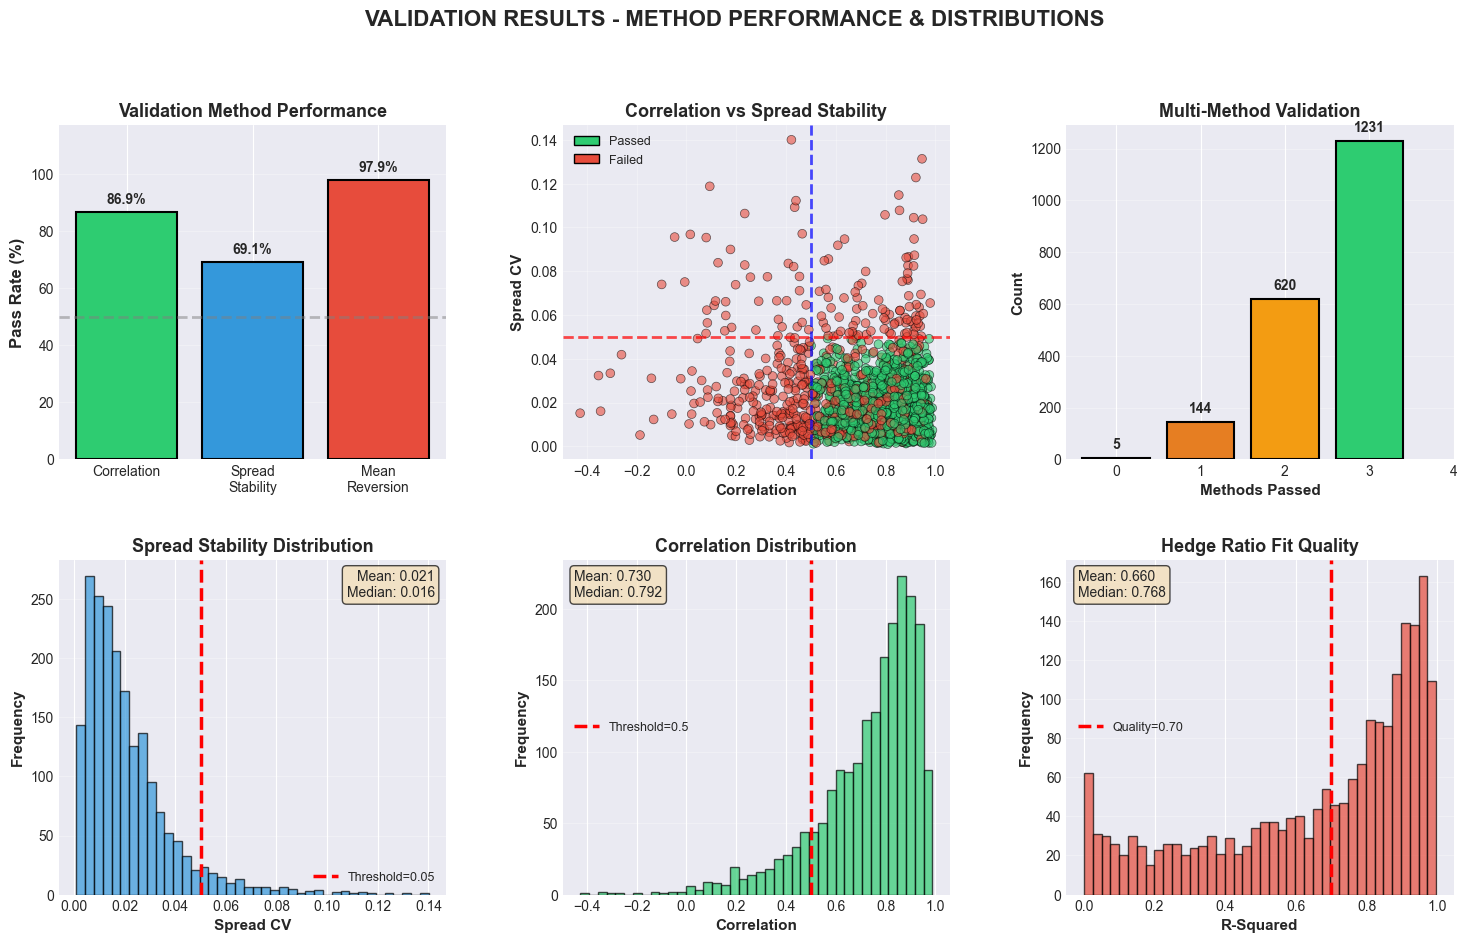

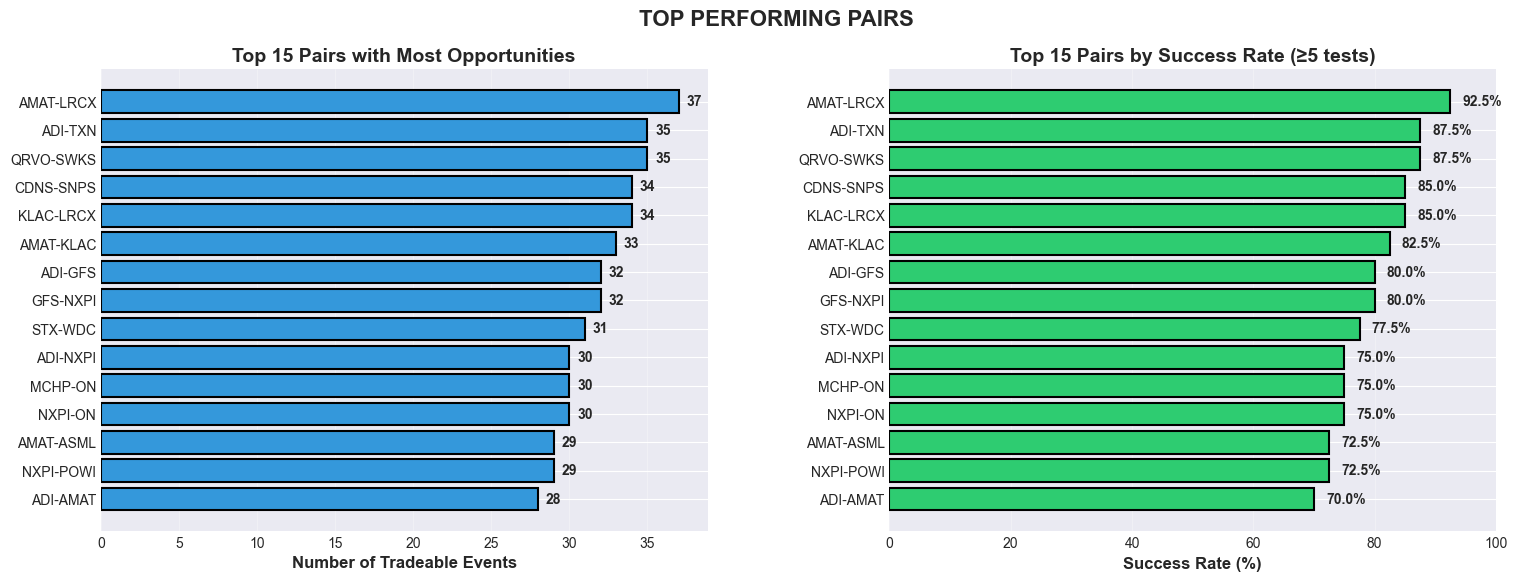


VISUALIZATIONS COMPLETE

Generated:
  • Figure 1: Method performance and statistical distributions
  • Figure 2: Top performing pairs analysis


In [12]:
# ============================================================================
# CELL 5: VISUALIZE RESULTS IN NOTEBOOK
# ============================================================================

print(f"\n{'='*80}")
print("CREATING VISUALIZATIONS")
print(f"{'='*80}")

if len(df_validation) == 0:
    print("\nNo results to visualize. Run Cell 2 first.")
else:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.gridspec as gridspec
    
    # Set style for better looking plots
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # ========================================================================
    # FIGURE 1: METHOD PERFORMANCE AND DISTRIBUTIONS (3x2 grid)
    # ========================================================================
    
    fig1 = plt.figure(figsize=(18, 10))
    gs1 = gridspec.GridSpec(2, 3, figure=fig1, hspace=0.3, wspace=0.3)
    
    # Plot 1.1: Method Pass Rates
    ax1 = fig1.add_subplot(gs1[0, 0])
    
    methods = {
        'Correlation': 'corr_passed',
        'Spread\nStability': 'spread_passed',
        'Cointegration': 'coint_passed',
        'Mean\nReversion': 'mr_passed'
    }
    
    method_names = []
    pass_rates = []
    
    for name, col in methods.items():
        if col in df_validation.columns:
            total = df_validation[col].notna().sum()
            if total > 0:
                method_names.append(name)
                pass_rates.append(df_validation[col].sum() / total * 100)
    
    if len(method_names) > 0:
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12'][:len(method_names)]
        bars = ax1.bar(method_names, pass_rates, color=colors, edgecolor='black', linewidth=1.5)
        ax1.set_ylabel('Pass Rate (%)', fontsize=12, fontweight='bold')
        ax1.set_title('Validation Method Performance', fontsize=13, fontweight='bold')
        ax1.set_ylim([0, max(pass_rates) * 1.2 if pass_rates else 100])
        ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=2)
        ax1.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 1.2: Correlation vs Spread CV Scatter
    ax2 = fig1.add_subplot(gs1[0, 1])
    
    if 'correlation' in df_validation.columns and 'spread_cv' in df_validation.columns:
        scatter_data = df_validation.dropna(subset=['correlation', 'spread_cv'])
        scatter_data = scatter_data[scatter_data['spread_cv'] < 0.5]  # Remove outliers
        
        if len(scatter_data) > 0:
            if 'overall_passed' in scatter_data.columns:
                colors = scatter_data['overall_passed'].map({True: '#2ecc71', False: '#e74c3c'})
                ax2.scatter(scatter_data['correlation'], scatter_data['spread_cv'],
                           c=colors, alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
                
                # Add legend
                from matplotlib.patches import Patch
                legend_elements = [
                    Patch(facecolor='#2ecc71', edgecolor='black', label='Passed'),
                    Patch(facecolor='#e74c3c', edgecolor='black', label='Failed')
                ]
                ax2.legend(handles=legend_elements, loc='upper left', fontsize=9)
            else:
                ax2.scatter(scatter_data['correlation'], scatter_data['spread_cv'],
                           c='#3498db', alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
            
            ax2.axhline(y=SPREAD_CV_THRESHOLD, color='red', linestyle='--', 
                       label=f'CV={SPREAD_CV_THRESHOLD}', linewidth=2, alpha=0.7)
            ax2.axvline(x=CORRELATION_THRESHOLD, color='blue', linestyle='--',
                       label=f'Corr={CORRELATION_THRESHOLD}', linewidth=2, alpha=0.7)
            
            ax2.set_xlabel('Correlation', fontsize=11, fontweight='bold')
            ax2.set_ylabel('Spread CV', fontsize=11, fontweight='bold')
            ax2.set_title('Correlation vs Spread Stability', fontsize=13, fontweight='bold')
            ax2.grid(alpha=0.3)
    
    # Plot 1.3: Methods Passed Distribution
    ax3 = fig1.add_subplot(gs1[0, 2])
    
    if 'methods_passed' in df_validation.columns:
        methods_dist = df_validation['methods_passed'].value_counts().sort_index()
        
        colors_gradient = ['#e74c3c', '#e67e22', '#f39c12', '#2ecc71', '#27ae60']
        bar_colors = [colors_gradient[min(i, len(colors_gradient)-1)] for i in methods_dist.index]
        
        bars = ax3.bar(methods_dist.index, methods_dist.values, 
                      color=bar_colors, edgecolor='black', linewidth=1.5)
        ax3.set_xlabel('Methods Passed', fontsize=11, fontweight='bold')
        ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
        ax3.set_title('Multi-Method Validation', fontsize=13, fontweight='bold')
        ax3.set_xticks(range(0, 5))
        ax3.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + max(methods_dist.values)*0.02,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 1.4: Spread CV Distribution
    ax4 = fig1.add_subplot(gs1[1, 0])
    
    if 'spread_cv' in df_validation.columns:
        cv_data = df_validation['spread_cv'].dropna()
        cv_data_clean = cv_data[cv_data < 0.5]
        
        if len(cv_data_clean) > 0:
            ax4.hist(cv_data_clean, bins=40, color='#3498db', alpha=0.7, edgecolor='black')
            ax4.axvline(x=SPREAD_CV_THRESHOLD, color='red', linestyle='--', 
                       linewidth=2.5, label=f'Threshold={SPREAD_CV_THRESHOLD}')
            ax4.set_xlabel('Spread CV', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax4.set_title('Spread Stability Distribution', fontsize=13, fontweight='bold')
            ax4.legend(fontsize=9)
            ax4.grid(axis='y', alpha=0.3)
            
            stats_text = f'Mean: {cv_data_clean.mean():.3f}\nMedian: {cv_data_clean.median():.3f}'
            ax4.text(0.97, 0.97, stats_text, transform=ax4.transAxes,
                    fontsize=10, va='top', ha='right',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Plot 1.5: Correlation Distribution
    ax5 = fig1.add_subplot(gs1[1, 1])
    
    if 'correlation' in df_validation.columns:
        corr_data = df_validation['correlation'].dropna()
        
        if len(corr_data) > 0:
            ax5.hist(corr_data, bins=40, color='#2ecc71', alpha=0.7, edgecolor='black')
            ax5.axvline(x=CORRELATION_THRESHOLD, color='red', linestyle='--',
                       linewidth=2.5, label=f'Threshold={CORRELATION_THRESHOLD}')
            ax5.set_xlabel('Correlation', fontsize=11, fontweight='bold')
            ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax5.set_title('Correlation Distribution', fontsize=13, fontweight='bold')
            ax5.legend(fontsize=9)
            ax5.grid(axis='y', alpha=0.3)
            
            stats_text = f'Mean: {corr_data.mean():.3f}\nMedian: {corr_data.median():.3f}'
            ax5.text(0.03, 0.97, stats_text, transform=ax5.transAxes,
                    fontsize=10, va='top', ha='left',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Plot 1.6: R-Squared Distribution
    ax6 = fig1.add_subplot(gs1[1, 2])
    
    if 'r_squared' in df_validation.columns:
        r2_data = df_validation['r_squared'].dropna()
        
        if len(r2_data) > 0:
            ax6.hist(r2_data, bins=40, color='#e74c3c', alpha=0.7, edgecolor='black')
            ax6.axvline(x=0.70, color='red', linestyle='--',
                       linewidth=2.5, label='Quality=0.70')
            ax6.set_xlabel('R-Squared', fontsize=11, fontweight='bold')
            ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
            ax6.set_title('Hedge Ratio Fit Quality', fontsize=13, fontweight='bold')
            ax6.legend(fontsize=9)
            ax6.grid(axis='y', alpha=0.3)
            
            stats_text = f'Mean: {r2_data.mean():.3f}\nMedian: {r2_data.median():.3f}'
            ax6.text(0.03, 0.97, stats_text, transform=ax6.transAxes,
                    fontsize=10, va='top', ha='left',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    fig1.suptitle('VALIDATION RESULTS - METHOD PERFORMANCE & DISTRIBUTIONS', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # FIGURE 2: TOP PAIRS AND OPPORTUNITIES
    # ========================================================================
    
    if 'overall_passed' in df_validation.columns:
        tradeable_subset = df_validation[df_validation['overall_passed'] == True]
        
        if len(tradeable_subset) > 0:
            fig2 = plt.figure(figsize=(18, 6))
            gs2 = gridspec.GridSpec(1, 2, figure=fig2, hspace=0.3, wspace=0.3)
            
            # Plot 2.1: Top Pairs by Opportunity Count
            ax7 = fig2.add_subplot(gs2[0, 0])
            
            pair_counts = tradeable_subset.groupby(['ticker_a', 'ticker_b']).size().reset_index(name='count')
            top_pairs = pair_counts.nlargest(15, 'count')
            
            pair_labels = [f"{row['ticker_a']}-{row['ticker_b']}" for _, row in top_pairs.iterrows()]
            
            bars = ax7.barh(range(len(top_pairs)), top_pairs['count'], 
                           color='#3498db', edgecolor='black', linewidth=1.5)
            ax7.set_yticks(range(len(top_pairs)))
            ax7.set_yticklabels(pair_labels, fontsize=10)
            ax7.set_xlabel('Number of Tradeable Events', fontsize=12, fontweight='bold')
            ax7.set_title('Top 15 Pairs with Most Opportunities', fontsize=14, fontweight='bold')
            ax7.grid(axis='x', alpha=0.3)
            ax7.invert_yaxis()
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax7.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                        f'{int(width)}', ha='left', va='center', fontsize=10, fontweight='bold')
            
            # Plot 2.2: Success Rate by Pair
            ax8 = fig2.add_subplot(gs2[0, 1])
            
            # Calculate success rate for each pair
            pair_stats = df_validation.groupby(['ticker_a', 'ticker_b']).agg({
                'overall_passed': ['sum', 'count']
            }).reset_index()
            pair_stats.columns = ['ticker_a', 'ticker_b', 'opportunities', 'total']
            pair_stats['success_rate'] = pair_stats['opportunities'] / pair_stats['total'] * 100
            pair_stats = pair_stats[pair_stats['total'] >= 5]  # At least 5 tests
            top_success = pair_stats.nlargest(15, 'success_rate')
            
            pair_labels_success = [f"{row['ticker_a']}-{row['ticker_b']}" for _, row in top_success.iterrows()]
            
            bars = ax8.barh(range(len(top_success)), top_success['success_rate'], 
                           color='#2ecc71', edgecolor='black', linewidth=1.5)
            ax8.set_yticks(range(len(top_success)))
            ax8.set_yticklabels(pair_labels_success, fontsize=10)
            ax8.set_xlabel('Success Rate (%)', fontsize=12, fontweight='bold')
            ax8.set_title('Top 15 Pairs by Success Rate (≥5 tests)', fontsize=14, fontweight='bold')
            ax8.grid(axis='x', alpha=0.3)
            ax8.invert_yaxis()
            ax8.set_xlim([0, 100])
            
            for i, bar in enumerate(bars):
                width = bar.get_width()
                ax8.text(width + 2, bar.get_y() + bar.get_height()/2.,
                        f'{width:.1f}%', ha='left', va='center', fontsize=10, fontweight='bold')
            
            fig2.suptitle('TOP PERFORMING PAIRS', fontsize=16, fontweight='bold', y=0.98)
            plt.tight_layout()
            plt.show()
            
        else:
            print("\n⚠ No tradeable opportunities found - skipping pair visualization")
    
    print(f"\n{'='*80}")
    print("VISUALIZATIONS COMPLETE")
    print(f"{'='*80}")
    print(f"\nGenerated:")
    print(f"  • Figure 1: Method performance and statistical distributions")
    if 'overall_passed' in df_validation.columns and len(tradeable_subset) > 0:
        print(f"  • Figure 2: Top performing pairs analysis")


VISUALIZING TRADEABLE OPPORTUNITIES

Found 1254 tradeable opportunities
Selecting top opportunities for visualization...

Visualizing 6 opportunities:
  • GFS-NXPI at 2025-05-19 18:30:00+00:00 (CV: 0.0010, Corr: 0.809)
  • STM-TXN at 2025-06-20 13:30:00+00:00 (CV: 0.0012, Corr: 0.510)
  • AMAT-KLAC at 2025-06-24 13:30:00+00:00 (CV: 0.0013, Corr: 0.792)
  • AMAT-LRCX at 2025-03-11 13:30:00+00:00 (CV: 0.0030, Corr: 0.896)
  • AMAT-LRCX at 2025-03-11 13:30:00+00:00 (CV: 0.0219, Corr: 0.981)
  • AMAT-LRCX at 2025-03-13 16:30:00+00:00 (CV: 0.0037, Corr: 0.917)

GENERATING DETAILED VISUALIZATIONS



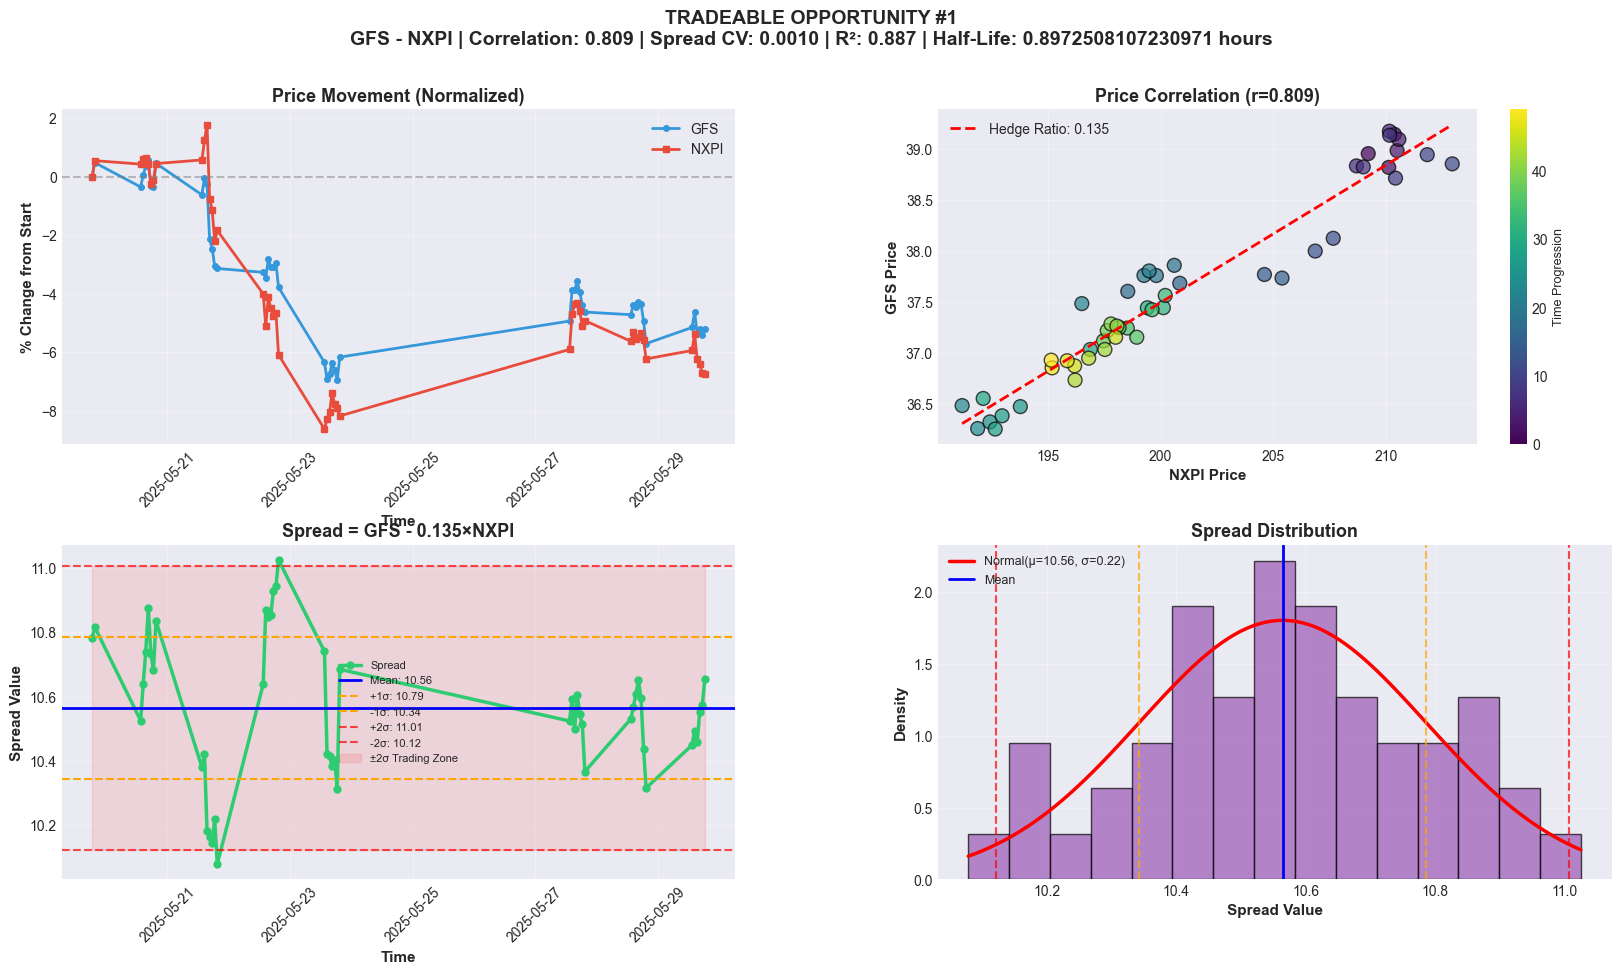


OPPORTUNITY #1: GFS-NXPI
Timestamp: 2025-05-19 18:30:00+00:00
Window: 50 hours (50 observations)

Statistics:
  Correlation: 0.8091
  Spread CV: 0.0010 (lower = better)
  R-Squared: 0.8874
  Half-Life: 0.90 hours

Spread Metrics:
  Mean: 10.5647
  Std Dev: 0.2213
  Current: 10.6538
  Z-Score: 0.40σ

Trading Setup:
  Hedge Ratio: 0.1346
  Strategy: GFS - 0.1346 × NXPI
  ✓ Spread near mean (0.40σ) - wait for signal

Price Levels at Detection:
  GFS: $36.92
  NXPI: $195.14



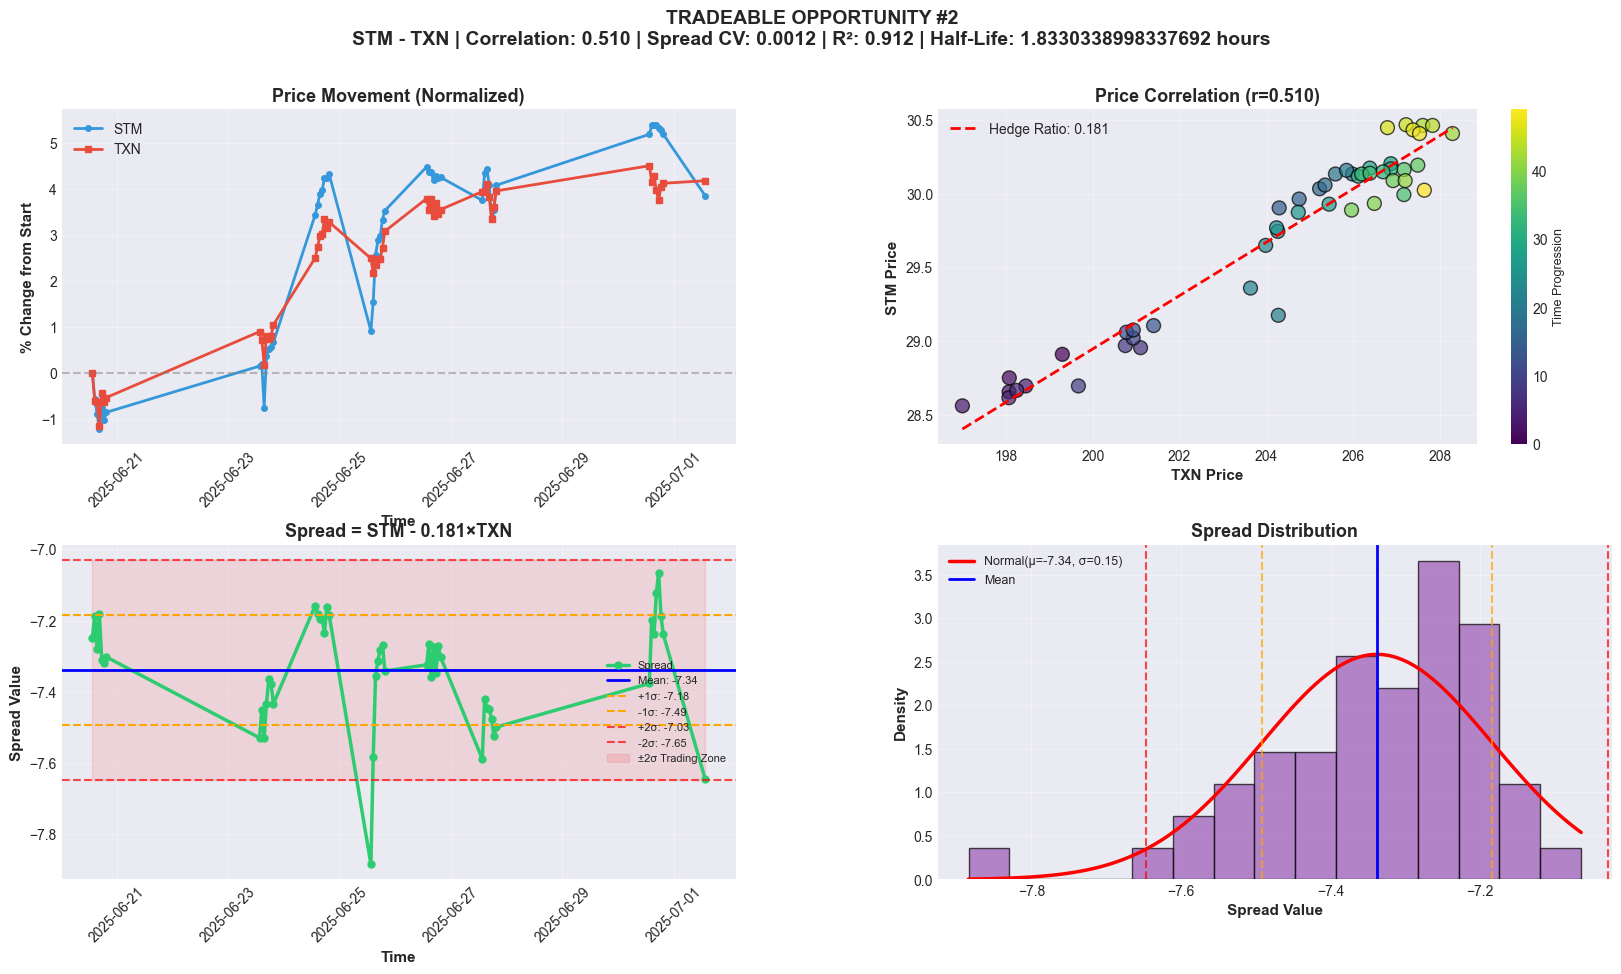


OPPORTUNITY #2: STM-TXN
Timestamp: 2025-06-20 13:30:00+00:00
Window: 50 hours (50 observations)

Statistics:
  Correlation: 0.5103
  Spread CV: 0.0012 (lower = better)
  R-Squared: 0.9124
  Half-Life: 1.83 hours

Spread Metrics:
  Mean: -7.3379
  Std Dev: 0.1543
  Current: -7.6437
  Z-Score: -1.98σ

Trading Setup:
  Hedge Ratio: 0.1814
  Strategy: STM - 0.1814 × TXN
  ⚠️  Spread at -1.98σ (approaching signal)

Price Levels at Detection:
  STM: $30.02
  TXN: $207.63



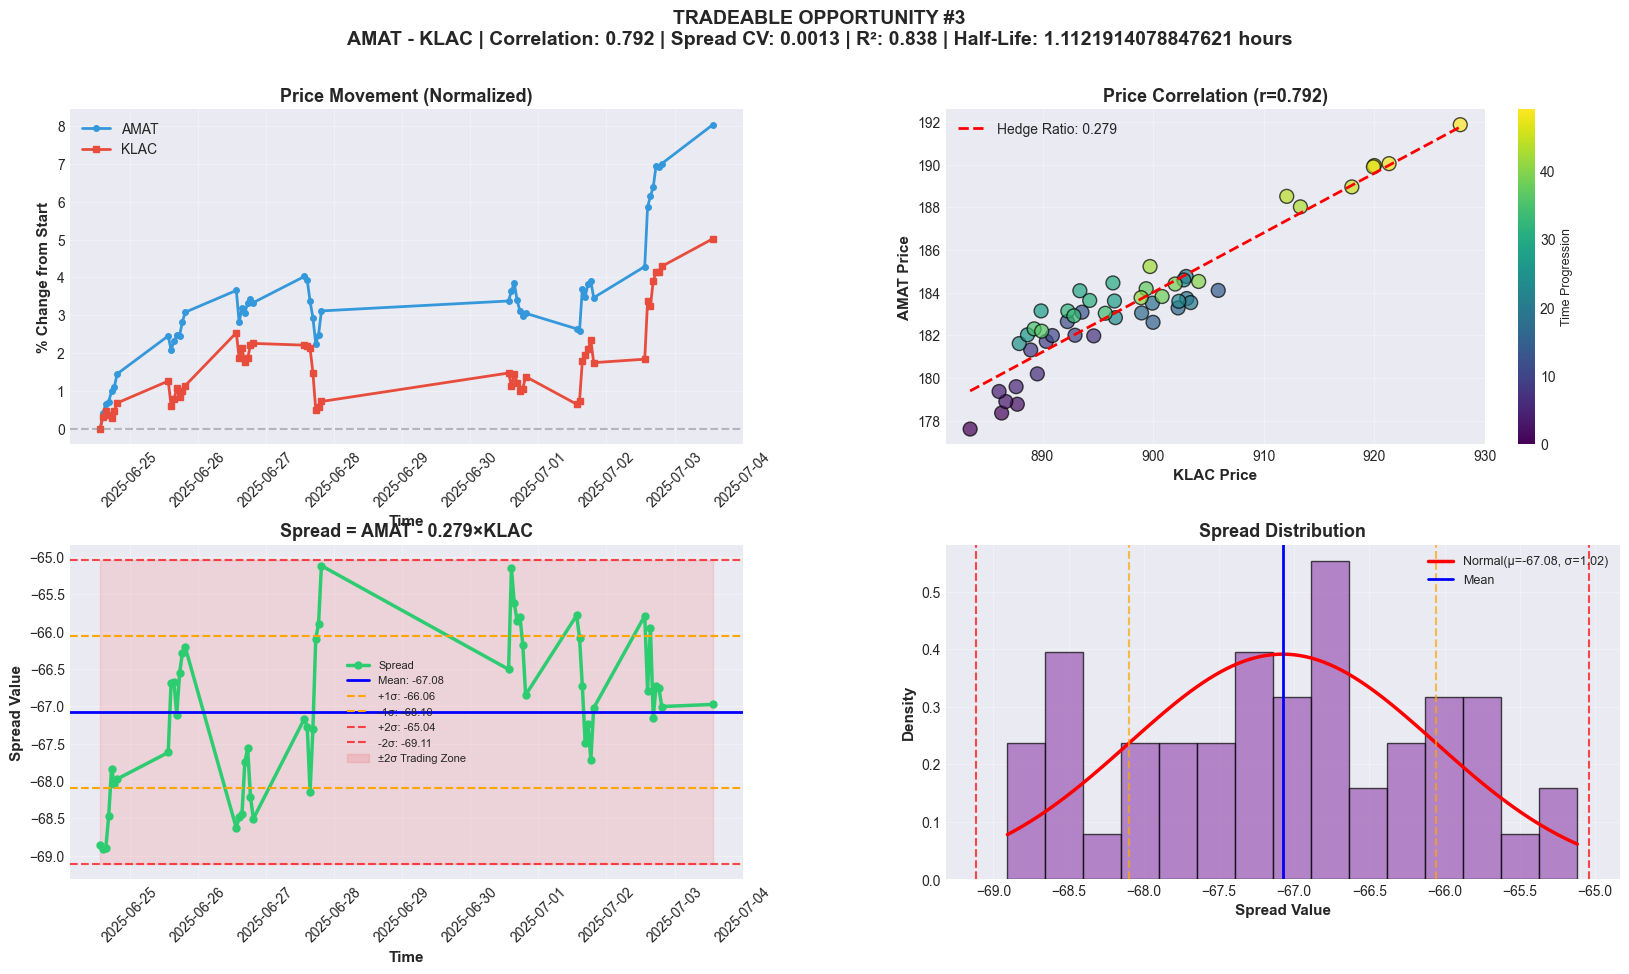


OPPORTUNITY #3: AMAT-KLAC
Timestamp: 2025-06-24 13:30:00+00:00
Window: 50 hours (50 observations)

Statistics:
  Correlation: 0.7922
  Spread CV: 0.0013 (lower = better)
  R-Squared: 0.8379
  Half-Life: 1.11 hours

Spread Metrics:
  Mean: -67.0775
  Std Dev: 1.0184
  Current: -66.9748
  Z-Score: 0.10σ

Trading Setup:
  Hedge Ratio: 0.2790
  Strategy: AMAT - 0.2790 × KLAC
  ✓ Spread near mean (0.10σ) - wait for signal

Price Levels at Detection:
  AMAT: $191.87
  KLAC: $927.80



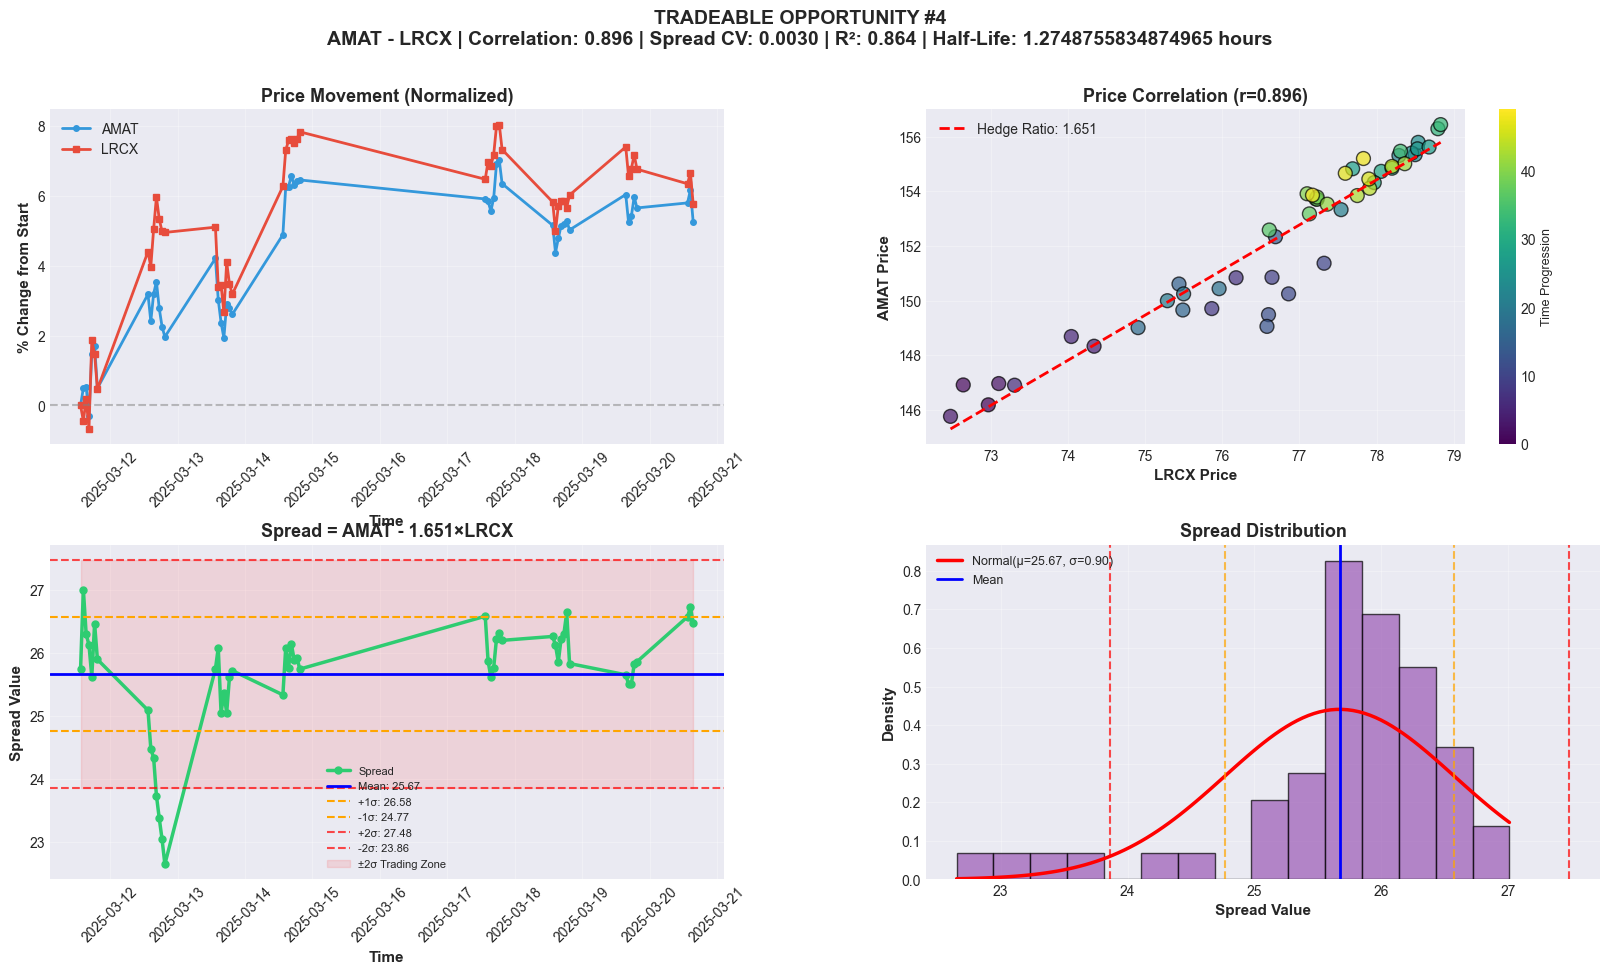


OPPORTUNITY #4: AMAT-LRCX
Timestamp: 2025-03-11 13:30:00+00:00
Window: 50 hours (50 observations)

Statistics:
  Correlation: 0.8957
  Spread CV: 0.0030 (lower = better)
  R-Squared: 0.8644
  Half-Life: 1.27 hours

Spread Metrics:
  Mean: 25.6706
  Std Dev: 0.9050
  Current: 26.4797
  Z-Score: 0.89σ

Trading Setup:
  Hedge Ratio: 1.6506
  Strategy: AMAT - 1.6506 × LRCX
  ✓ Spread near mean (0.89σ) - wait for signal

Price Levels at Detection:
  AMAT: $153.86
  LRCX: $77.17



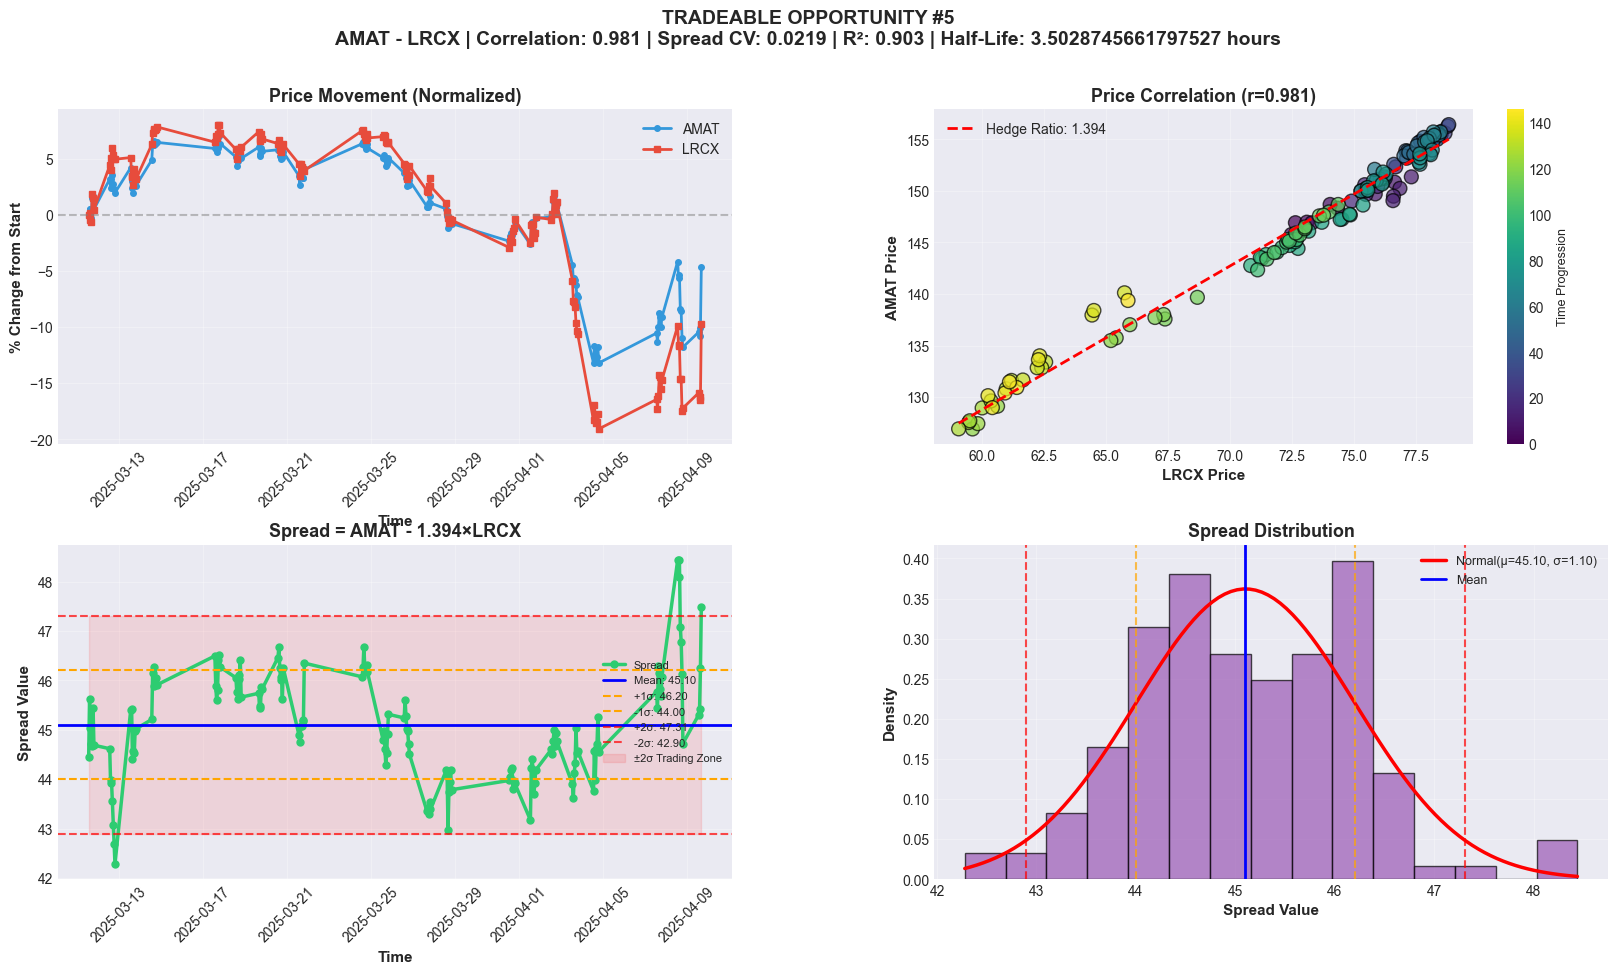


OPPORTUNITY #5: AMAT-LRCX
Timestamp: 2025-03-11 13:30:00+00:00
Window: 147 hours (147 observations)

Statistics:
  Correlation: 0.9806
  Spread CV: 0.0219 (lower = better)
  R-Squared: 0.9033
  Half-Life: 3.50 hours

Spread Metrics:
  Mean: 45.1023
  Std Dev: 1.1021
  Current: 47.4919
  Z-Score: 2.17σ

Trading Setup:
  Hedge Ratio: 1.3944
  Strategy: AMAT - 1.3944 × LRCX
  📊 ENTRY SIGNAL: Spread at +2.17σ
     → SHORT the spread (Short AMAT, Long LRCX)

Price Levels at Detection:
  AMAT: $139.37
  LRCX: $65.89



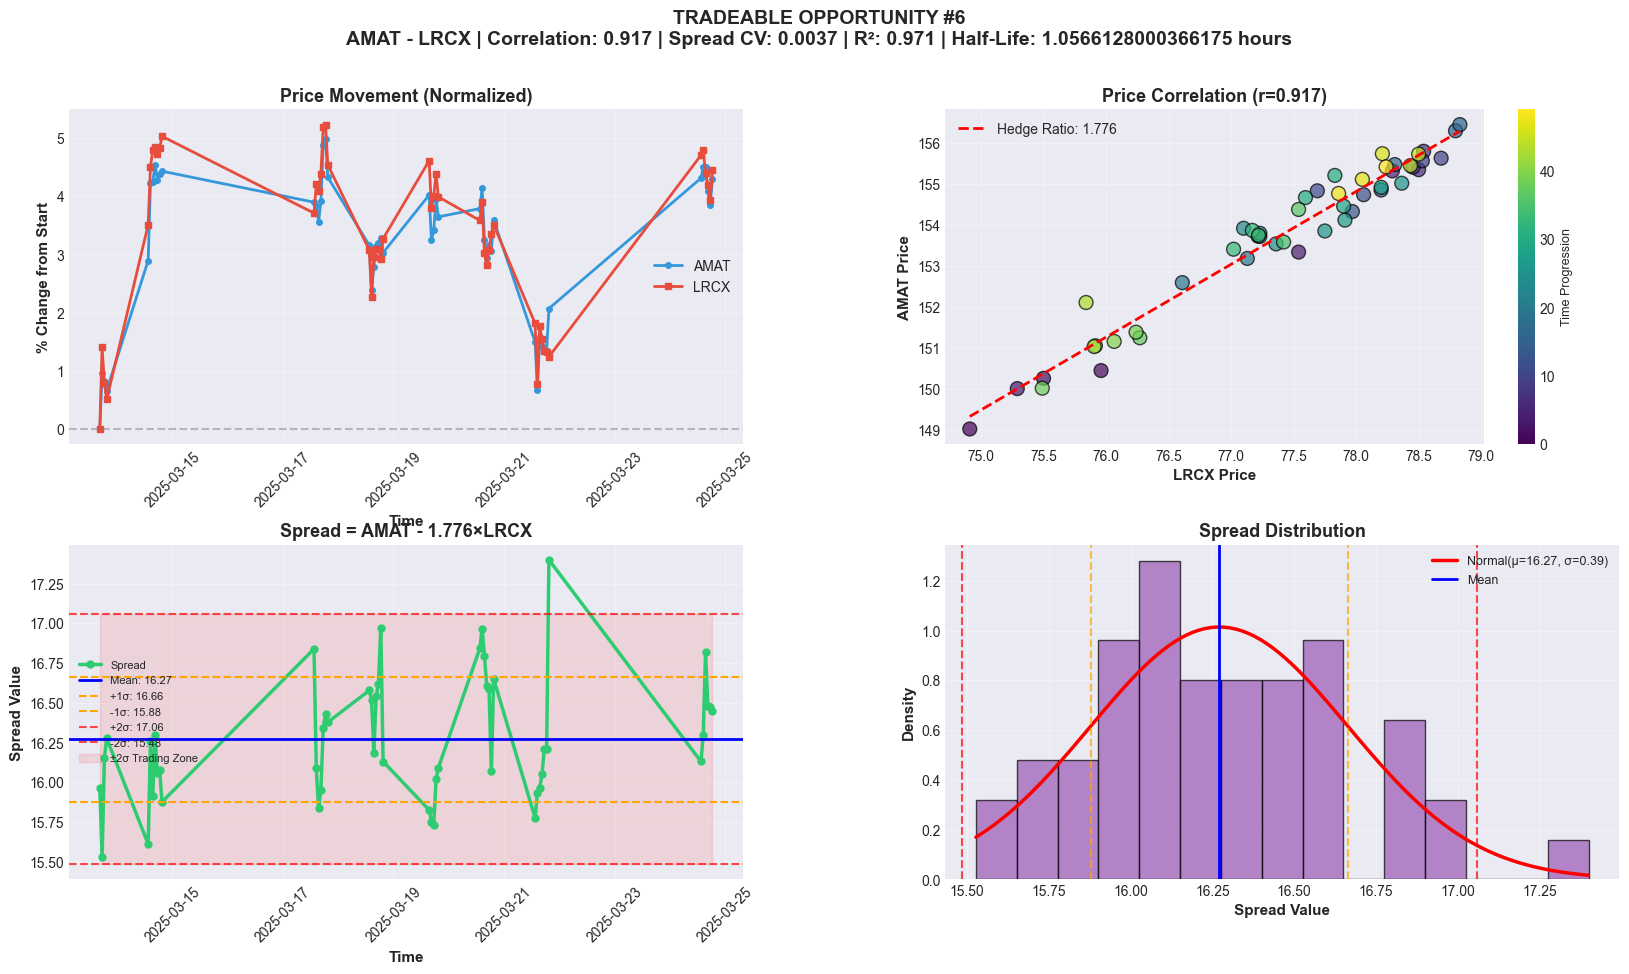


OPPORTUNITY #6: AMAT-LRCX
Timestamp: 2025-03-13 16:30:00+00:00
Window: 50 hours (50 observations)

Statistics:
  Correlation: 0.9170
  Spread CV: 0.0037 (lower = better)
  R-Squared: 0.9705
  Half-Life: 1.06 hours

Spread Metrics:
  Mean: 16.2708
  Std Dev: 0.3933
  Current: 16.4472
  Z-Score: 0.45σ

Trading Setup:
  Hedge Ratio: 1.7761
  Strategy: AMAT - 1.7761 × LRCX
  ✓ Spread near mean (0.45σ) - wait for signal

Price Levels at Detection:
  AMAT: $155.41
  LRCX: $78.24


VISUALIZATION COMPLETE

Generated 6 detailed opportunity visualizations

Each visualization shows:
  • Panel 1: Normalized price movements (% change)
  • Panel 2: Price correlation scatter with hedge ratio
  • Panel 3: Spread over time with ±1σ and ±2σ bands
  • Panel 4: Spread distribution vs normal curve

Trading signals based on Z-score:
  • |Z| > 2.0σ → Strong entry signal
  • |Z| > 1.5σ → Moderate entry signal
  • |Z| < 1.0σ → Wait for signal


In [13]:
# ============================================================================
# CELL 6: VISUALIZE INDIVIDUAL TRADEABLE OPPORTUNITIES
# ============================================================================

print(f"\n{'='*80}")
print("VISUALIZING TRADEABLE OPPORTUNITIES")
print(f"{'='*80}")

if 'df_validation' not in locals() or len(df_validation) == 0:
    print("\nNo validation results found. Run Cell 2 first.")
else:
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    
    # Get tradeable opportunities
    tradeable = df_validation[df_validation['overall_passed'] == True].copy()
    
    if len(tradeable) == 0:
        print("\nNo tradeable opportunities to visualize.")
    else:
        print(f"\nFound {len(tradeable)} tradeable opportunities")
        print(f"Selecting top opportunities for visualization...\n")
        
        # ====================================================================
        # SELECT OPPORTUNITIES TO VISUALIZE
        # ====================================================================
        
        # Sort by quality (lowest spread CV = best quality)
        tradeable_sorted = tradeable.sort_values('spread_cv')
        
        # Get different quality tiers
        excellent = tradeable_sorted.head(3)  # Top 3 by spread CV
        good = tradeable_sorted.iloc[len(tradeable)//2:len(tradeable)//2 + 3]  # Middle 3
        
        # Also get some from top pairs
        top_pairs = tradeable.groupby(['ticker_a', 'ticker_b']).size().reset_index(name='count')
        top_pair = top_pairs.nlargest(1, 'count').iloc[0]
        from_top_pair = tradeable[
            (tradeable['ticker_a'] == top_pair['ticker_a']) & 
            (tradeable['ticker_b'] == top_pair['ticker_b'])
        ].head(3)
        
        # Combine selections (remove duplicates)
        selected = pd.concat([excellent, from_top_pair]).drop_duplicates()
        selected = selected.head(6)  # Max 6 opportunities
        
        print(f"Visualizing {len(selected)} opportunities:")
        for idx, row in selected.iterrows():
            print(f"  • {row['ticker_a']}-{row['ticker_b']} at {row['timestamp']} " 
                  f"(CV: {row['spread_cv']:.4f}, Corr: {row['correlation']:.3f})")
        
        # ====================================================================
        # VISUALIZATION FUNCTION
        # ====================================================================
        
        def visualize_opportunity(opportunity_row, ts_df, fig_num):
            """
            Create detailed 4-panel visualization for a single opportunity.
            """
            ticker_a = opportunity_row['ticker_a']
            ticker_b = opportunity_row['ticker_b']
            timestamp = opportunity_row['timestamp']
            window_hours = opportunity_row['window_hours']
            
            # Extract price data using observation-based forward window
            prices_a = get_price_window(ticker_a, timestamp, window_hours, ts_df, direction='forward')
            prices_b = get_price_window(ticker_b, timestamp, window_hours, ts_df, direction='forward')
            
            # Align prices
            common_idx = prices_a.index.intersection(prices_b.index)
            prices_a = prices_a.loc[common_idx]
            prices_b = prices_b.loc[common_idx]
            
            if len(prices_a) < 3:
                print(f"\n⚠ Skipping {ticker_a}-{ticker_b}: insufficient data")
                return
            
            # Calculate hedge ratio and spread
            from sklearn.linear_model import LinearRegression
            X = prices_b.values.reshape(-1, 1)
            y = prices_a.values
            model = LinearRegression()
            model.fit(X, y)
            hedge_ratio = model.coef_[0]
            
            spread = prices_a - hedge_ratio * prices_b
            spread_mean = spread.mean()
            spread_std = spread.std()
            
            # Normalize prices for comparison
            norm_a = (prices_a / prices_a.iloc[0] - 1) * 100  # % change
            norm_b = (prices_b / prices_b.iloc[0] - 1) * 100
            
            # Create figure
            fig = plt.figure(figsize=(20, 10))
            gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)
            
            # ================================================================
            # PANEL 1: Normalized Price Movement (Top Left)
            # ================================================================
            ax1 = fig.add_subplot(gs[0, 0])
            
            ax1.plot(common_idx, norm_a, label=ticker_a, color='#3498db', 
                    linewidth=2, marker='o', markersize=4)
            ax1.plot(common_idx, norm_b, label=ticker_b, color='#e74c3c', 
                    linewidth=2, marker='s', markersize=4)
            
            ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax1.set_xlabel('Time', fontsize=11, fontweight='bold')
            ax1.set_ylabel('% Change from Start', fontsize=11, fontweight='bold')
            ax1.set_title('Price Movement (Normalized)', fontsize=13, fontweight='bold')
            ax1.legend(fontsize=10, loc='best')
            ax1.grid(alpha=0.3)
            
            # Rotate x-axis labels
            ax1.tick_params(axis='x', rotation=45)
            
            # ================================================================
            # PANEL 2: Correlation Scatter (Top Right)
            # ================================================================
            ax2 = fig.add_subplot(gs[0, 1])
            
            ax2.scatter(prices_b, prices_a, alpha=0.7, s=100, 
                       c=range(len(prices_a)), cmap='viridis', edgecolors='black')
            
            # Add regression line
            x_line = np.array([prices_b.min(), prices_b.max()])
            y_line = hedge_ratio * x_line + model.intercept_
            ax2.plot(x_line, y_line, 'r--', linewidth=2, label=f'Hedge Ratio: {hedge_ratio:.3f}')
            
            ax2.set_xlabel(f'{ticker_b} Price', fontsize=11, fontweight='bold')
            ax2.set_ylabel(f'{ticker_a} Price', fontsize=11, fontweight='bold')
            ax2.set_title(f'Price Correlation (r={opportunity_row["correlation"]:.3f})', 
                         fontsize=13, fontweight='bold')
            ax2.legend(fontsize=10)
            ax2.grid(alpha=0.3)
            
            # Add colorbar to show time progression
            sm = plt.cm.ScalarMappable(cmap='viridis', 
                                       norm=plt.Normalize(vmin=0, vmax=len(prices_a)-1))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax2)
            cbar.set_label('Time Progression', fontsize=9)
            
            # ================================================================
            # PANEL 3: Spread Over Time (Bottom Left)
            # ================================================================
            ax3 = fig.add_subplot(gs[1, 0])
            
            ax3.plot(common_idx, spread, color='#2ecc71', linewidth=2.5, 
                    marker='o', markersize=5, label='Spread')
            
            # Add mean and standard deviation bands
            ax3.axhline(y=spread_mean, color='blue', linestyle='-', 
                       linewidth=2, label=f'Mean: {spread_mean:.2f}')
            ax3.axhline(y=spread_mean + spread_std, color='orange', linestyle='--', 
                       linewidth=1.5, label=f'+1σ: {spread_mean + spread_std:.2f}')
            ax3.axhline(y=spread_mean - spread_std, color='orange', linestyle='--', 
                       linewidth=1.5, label=f'-1σ: {spread_mean - spread_std:.2f}')
            ax3.axhline(y=spread_mean + 2*spread_std, color='red', linestyle='--', 
                       linewidth=1.5, alpha=0.7, label=f'+2σ: {spread_mean + 2*spread_std:.2f}')
            ax3.axhline(y=spread_mean - 2*spread_std, color='red', linestyle='--', 
                       linewidth=1.5, alpha=0.7, label=f'-2σ: {spread_mean - 2*spread_std:.2f}')
            
            # Shade the ±2σ region
            ax3.fill_between(common_idx, 
                            spread_mean - 2*spread_std, 
                            spread_mean + 2*spread_std,
                            alpha=0.1, color='red', label='±2σ Trading Zone')
            
            ax3.set_xlabel('Time', fontsize=11, fontweight='bold')
            ax3.set_ylabel('Spread Value', fontsize=11, fontweight='bold')
            ax3.set_title(f'Spread = {ticker_a} - {hedge_ratio:.3f}×{ticker_b}', 
                         fontsize=13, fontweight='bold')
            ax3.legend(fontsize=8, loc='best')
            ax3.grid(alpha=0.3)
            ax3.tick_params(axis='x', rotation=45)
            
            # ================================================================
            # PANEL 4: Spread Distribution & Mean Reversion (Bottom Right)
            # ================================================================
            ax4 = fig.add_subplot(gs[1, 1])
            
            # Histogram of spread values
            n, bins, patches = ax4.hist(spread, bins=15, color='#9b59b6', 
                                       alpha=0.7, edgecolor='black', density=True)
            
            # Overlay normal distribution
            from scipy.stats import norm
            x_norm = np.linspace(spread.min(), spread.max(), 100)
            y_norm = norm.pdf(x_norm, spread_mean, spread_std)
            ax4.plot(x_norm, y_norm, 'r-', linewidth=2.5, 
                    label=f'Normal(μ={spread_mean:.2f}, σ={spread_std:.2f})')
            
            # Add mean line
            ax4.axvline(x=spread_mean, color='blue', linestyle='-', 
                       linewidth=2, label='Mean')
            
            # Add ±1σ and ±2σ lines
            ax4.axvline(x=spread_mean + spread_std, color='orange', 
                       linestyle='--', linewidth=1.5, alpha=0.7)
            ax4.axvline(x=spread_mean - spread_std, color='orange', 
                       linestyle='--', linewidth=1.5, alpha=0.7)
            ax4.axvline(x=spread_mean + 2*spread_std, color='red', 
                       linestyle='--', linewidth=1.5, alpha=0.7)
            ax4.axvline(x=spread_mean - 2*spread_std, color='red', 
                       linestyle='--', linewidth=1.5, alpha=0.7)
            
            ax4.set_xlabel('Spread Value', fontsize=11, fontweight='bold')
            ax4.set_ylabel('Density', fontsize=11, fontweight='bold')
            ax4.set_title('Spread Distribution', fontsize=13, fontweight='bold')
            ax4.legend(fontsize=9)
            ax4.grid(alpha=0.3)
            
            # ================================================================
            # Main Title with Metrics
            # ================================================================
            metrics_text = (
                f"{ticker_a} - {ticker_b} | "
                f"Correlation: {opportunity_row['correlation']:.3f} | "
                f"Spread CV: {opportunity_row['spread_cv']:.4f} | "
                f"R²: {opportunity_row['r_squared']:.3f} | "
                f"Half-Life: {opportunity_row.get('half_life_hours', 'N/A')} hours"
            )
            
            if pd.notna(opportunity_row.get('half_life_hours')):
                metrics_text = metrics_text.replace('N/A', f"{opportunity_row['half_life_hours']:.1f}")
            
            fig.suptitle(
                f"TRADEABLE OPPORTUNITY #{fig_num}\n{metrics_text}",
                fontsize=14, fontweight='bold', y=0.98
            )
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
            
            # Print trading signals
            print(f"\n{'='*60}")
            print(f"OPPORTUNITY #{fig_num}: {ticker_a}-{ticker_b}")
            print(f"{'='*60}")
            print(f"Timestamp: {timestamp}")
            print(f"Window: {window_hours} hours ({len(prices_a)} observations)")
            print(f"\nStatistics:")
            print(f"  Correlation: {opportunity_row['correlation']:.4f}")
            print(f"  Spread CV: {opportunity_row['spread_cv']:.4f} (lower = better)")
            print(f"  R-Squared: {opportunity_row['r_squared']:.4f}")
            if pd.notna(opportunity_row.get('half_life_hours')):
                print(f"  Half-Life: {opportunity_row['half_life_hours']:.2f} hours")
            
            print(f"\nSpread Metrics:")
            print(f"  Mean: {spread_mean:.4f}")
            print(f"  Std Dev: {spread_std:.4f}")
            print(f"  Current: {spread.iloc[-1]:.4f}")
            print(f"  Z-Score: {(spread.iloc[-1] - spread_mean) / spread_std:.2f}σ")
            
            print(f"\nTrading Setup:")
            print(f"  Hedge Ratio: {hedge_ratio:.4f}")
            print(f"  Strategy: {ticker_a} - {hedge_ratio:.4f} × {ticker_b}")
            
            # Entry signals
            current_z = (spread.iloc[-1] - spread_mean) / spread_std
            if abs(current_z) > 2:
                if current_z > 2:
                    print(f"  📊 ENTRY SIGNAL: Spread at +{current_z:.2f}σ")
                    print(f"     → SHORT the spread (Short {ticker_a}, Long {ticker_b})")
                else:
                    print(f"  📊 ENTRY SIGNAL: Spread at {current_z:.2f}σ")
                    print(f"     → LONG the spread (Long {ticker_a}, Short {ticker_b})")
            elif abs(current_z) > 1:
                print(f"  ⚠️  Spread at {current_z:.2f}σ (approaching signal)")
            else:
                print(f"  ✓ Spread near mean ({current_z:.2f}σ) - wait for signal")
            
            print(f"\nPrice Levels at Detection:")
            print(f"  {ticker_a}: ${prices_a.iloc[-1]:.2f}")
            print(f"  {ticker_b}: ${prices_b.iloc[-1]:.2f}")
            print(f"{'='*60}\n")
        
        # ====================================================================
        # VISUALIZE SELECTED OPPORTUNITIES
        # ====================================================================
        
        print(f"\n{'='*80}")
        print("GENERATING DETAILED VISUALIZATIONS")
        print(f"{'='*80}\n")
        
        for fig_num, (idx, opportunity) in enumerate(selected.iterrows(), 1):
            try:
                visualize_opportunity(opportunity, ts_df, fig_num)
            except Exception as e:
                print(f"\n⚠ Error visualizing opportunity {fig_num}: {str(e)}")
                continue
        
        print(f"\n{'='*80}")
        print("VISUALIZATION COMPLETE")
        print(f"{'='*80}")
        print(f"\nGenerated {len(selected)} detailed opportunity visualizations")
        print(f"\nEach visualization shows:")
        print(f"  • Panel 1: Normalized price movements (% change)")
        print(f"  • Panel 2: Price correlation scatter with hedge ratio")
        print(f"  • Panel 3: Spread over time with ±1σ and ±2σ bands")
        print(f"  • Panel 4: Spread distribution vs normal curve")
        print(f"\nTrading signals based on Z-score:")
        print(f"  • |Z| > 2.0σ → Strong entry signal")
        print(f"  • |Z| > 1.5σ → Moderate entry signal")
        print(f"  • |Z| < 1.0σ → Wait for signal")